## 4: Feature extraction and selection
Extraction and selection of waveform characteristics from the processed PPG signal segments. Also performing EDA for the purposes of visualization and analysis of the selected characteristics.

#### Importing several libraries
These libraries are commonly used for data analysis and visualization.

In [1]:
# A library for data manipulation and analysis. 
# It provides data structures like DataFrames that allow to work with structured data efficiently.
import pandas as pd

# A library for numerical computations.
import numpy as np

# A plotting library that provides a wide range of functions for creating static, animated, and interactive visualizations.
from matplotlib import pyplot as plt

# A module from matplotlib allows for custom formatting of tick labels on plots
import matplotlib.ticker as ticker

# A library to perform 1-dimensional interpolation of data.
from scipy.interpolate import interp1d

# Generating random numbers or selecting random elements.
import random

#### Upload the proccessed data 
The uploading of the excel files was actually in the first code file that dealt with their management and processing.

In [2]:
run = '8'

# Read the Excel file of the train proccessed df into a DataFrame and concatenate the data frames of the proccessed df to one df
file_path1 = f'data/train_proccessed_df1_run{run}.xlsx'
file_path2 = f'data/train_proccessed_df2_run{run}.xlsx'
df1 = pd.read_excel(file_path1)
df2 = pd.read_excel(file_path2)
train_df = pd.concat([df1, df2])
train_df.reset_index(drop=True, inplace=True)

# Read the Excel file of the train proccessed norm df into a DataFrame and concatenate the 2 data frames of the proccessed norm df to one df
file_path1_norm = f'data/train_proccessed_norm_df1_run{run}.xlsx'
file_path2_norm = f'data/train_proccessed_norm_df2_run{run}.xlsx'
norm_df1 = pd.read_excel(file_path1_norm)
norm_df2 = pd.read_excel(file_path2_norm)
train_norm_df = pd.concat([norm_df1, norm_df2])
train_norm_df.reset_index(drop=True, inplace=True)

# Read the Excel file of the test df into a DataFrame
test_file_path = f'data/test_proccessed_df_run{run}.xlsx'
test_df = pd.read_excel(test_file_path)
test_df.reset_index(drop=True, inplace=True)

# Read the Excel file of the test norm df into a DataFrame
test_file_path_norm = f'data/test_proccessed_norm_df_run{run}.xlsx'
test_norm = pd.read_excel(test_file_path_norm)
test_norm.reset_index(drop=True, inplace=True)

#### Features extraction
125 different features were extracted, including information about the PPG waveform and information about the patients.

In [3]:
# Define X columns in the data frames for use in the features 
train_df['X'] =  train_df.index
test_df['X'] = test_df.index

In [4]:
def Define_Cycle(data):
    """
    This function takes a DataFrame containing PPG data with identified peaks and defines the cycles in the segment based on the last peak (min or max).
    
    Parameters:
        data (DataFrame): A DataFrame containing PPG data with a 'peak' column indicating the type of peak (min or max).
        
    Returns:
        start_peak (bool): A boolean value indicating whether the starting peak is a minimum (True) or maximum (False).
        cycles_data (DataFrame): A subset of the input data containing only the cycles in the segment.
    """
    
    # Find all the indices of the peaks in the segment
    peaks = data[data['peak'].notna()].copy()
    
    # Determine the starting peak based on the last peak type
    if peaks.iloc[-1]['peak'] == 'Min':
        start_ind = peaks[peaks['peak'] == 'Min'].index[0]
        start_peak = True
    else:
        start_ind = peaks[peaks['peak'] == 'Max'].index[0]
        start_peak = False
        
    # Return only the cycles in the segment starting from the identified peak
    cycles_data = data.loc[start_ind:]
    
    return start_peak, cycles_data

In [5]:
def Cut_And_Pad_Array(arr, length):
    """
    This function cuts an array of segment to a specified length and adds padding if the length is less than the specified length.

    Parameters:
        arr (ndarray): An array to be cut and padded.
        length (int): The desired length of the resulting array.

    Returns:
        last_arr (ndarray): The resulting array with the specified length, padded with NaN values if necessary.
    """
    
    # Cut the array to the specified length
    cut_arr = arr[-length:]  
    
    # Pad the array with NaN values to the specified length
    last_arr = np.pad(cut_arr, (length - len(cut_arr), 0), mode='constant', constant_values=np.nan)  #

    return last_arr

In [6]:
def Time_delta(df, n_part, features):
    """
    Calculates the time delta in each point of the BP measurement according to the baseline time.

    Args:
        df (DataFrame): DataFrame containing the BP measurement data.
        n_part (int): Integer representing the segment number.
        features (DataFrame): DataFrame to store the calculated features.
    """
    
    df['BaseLine_Time'] = pd.to_datetime(df['BaseLine_Time'])
    df['DataTime_BP'] = pd.to_datetime(df['DataTime_BP'])

    df['Time_Delta'] = df['DataTime_BP'] - df['BaseLine_Time']
    not_nan_value = df['Time_Delta'].notna()
    filtered_value = df.loc[not_nan_value, 'Time_Delta']
    
    features.loc[n_part-1, 'Time_Delta_BP'] = filtered_value.values[0]

In [7]:
def MetaData(df, n_part, features):
    """
    Extracts and stores the metadata (weight, gender, age) for each patient.

    Args:
        df (DataFrame): DataFrame containing the patient data.
        n_part (int): Integer representing the part number.
        features (DataFrame): DataFrame to store the extracted metadata.
    """
    
    weight = df['Weight'].unique()[0]
    gender = df['Gender'].unique()[0]
    if gender == 'M':
        gender = 0
    elif gender == 'F':
        gender = 1
    age = df['Age'].unique()[0]
    
    features.loc[n_part-1, 'Weight'] = weight
    features.loc[n_part-1, 'Gender'] = gender
    features.loc[n_part-1, 'Age'] = age

#### Group feature 1: Amplitude area
The first group of features is the area under the curve. This area reflects the changes in blood vessel tone and is therefore an important features for predicting blood pressure.

In [8]:
def Calc_Area_Feature(data, df, x_name, y_name):
    """
    This function calculates the area under the curve of a segment, which represents the pulse rising time.
    
    Parameters:
        data (DataFrame): A DataFrame containing PPG data with a 'peak' column indicating the type of peak (min or max).
        df (DataFrame): The original DataFrame containing PPG data with corresponding x and y values.
        x_name (str): The column name in df representing the x-axis values.
        y_name (str): The column name in df representing the y-axis values.
        
    Returns:
        area_cycles_arr (ndarray): An array containing the calculated areas for each cycle in the segment.
    """
    
    # Find all the indices of the peaks in the part
    peak_index = data[data['peak'].notna()].index
    area_cycles_arr = np.array([])
    
    # Calculate the area of each cycle and store the values in an array
    for i in range(2, len(peak_index), 2):
        cycle = df[peak_index[i-2]:peak_index[i]+1]
        dx = np.gradient(cycle[x_name])
        area_cycle = np.sum(dx * cycle[y_name])
        area_cycles_arr = np.append(area_cycles_arr, area_cycle.round(3))
    
    return area_cycles_arr

In [9]:
def Group_Feature_1_AREA(part_norm_df, part_df, norm_df, df, n_part, features, x_last):
    """
    This function creates the group feature 1: Area for a specific segment and adds it to the features DataFrame.

    Parameters:
        part_norm_df (DataFrame): The normalized DataFrame for the specific segment.
        part_df (DataFrame): The DataFrame for the specific segment.
        norm_df (DataFrame): The normalized DataFrame for the entire dataset.
        df (DataFrame): The DataFrame for the entire dataset.
        n_part (int): The part number.
        features (DataFrame): The DataFrame to which the feature columns will be added.
        x_last (int): The number of cycles to consider for the last x_last features.
    """
    
    area_norm = Calc_Area_Feature(part_norm_df, norm_df, 'norm_time(X)', 'norm_data(y)')
    area = Calc_Area_Feature(part_df, df, 'X', 'PLETH_trend_removel')

    # Average of all the cycles area in each part
    features.loc[n_part-1, 'F1_Area_Avg_Norm'] = np.mean(area_norm).round(6)
    features.loc[n_part-1, 'F1_Area_Avg'] = np.mean(area).round(6)

    # Std of all the cycles area in each part
    features.loc[n_part-1, 'F1_Area_Std_Norm'] = area_norm.std().round(6)
    features.loc[n_part-1, 'F1_Area_Std'] = area.std().round(6)

    # Last (x_last) cycles area
    for i in range(x_last):
        features.loc[n_part-1, f'F1_Area_cycle_Norm_(-{i+1})'] = Cut_And_Pad_Array(area_norm, x_last)[(x_last-1)-i]
        features.loc[n_part-1, f'F1_Area_cycle_(-{i+1})'] = Cut_And_Pad_Array(area, x_last)[(x_last-1)-i]

    # Average of the (x_last) last cycles area in each part
    features.loc[n_part-1, f'F1_Area_Avg_Last_{x_last}_Norm'] = np.nanmean(Cut_And_Pad_Array(area_norm, x_last)).round(6)
    features.loc[n_part-1, f'F1_Area_Avg_Last_{x_last}'] = np.nanmean(Cut_And_Pad_Array(area, x_last)).round(6)

    # Std of the (x_last) last cycles area in each part
    features.loc[n_part-1, f'F1_Area_Std_Last_{x_last}_Norm'] = np.nanstd(Cut_And_Pad_Array(area_norm, x_last)).round(6)
    features.loc[n_part-1, f'F1_Area_Std_Last_{x_last}'] = np.nanstd(Cut_And_Pad_Array(area, x_last)).round(6)

#### Group feature 2:  Width Amplitude
The second set of features is the amplitude width so set the amplitude width at 25%, 50% and 75%. They indicate the resistance of system tools. The set of width features were extracted from the normalized set only.

In [10]:
def Width(norm_df, peaks_index, i, high):
    """
    This function calculates the width of the amplitude according to a given parameter "high".
    
    Parameters:
        norm_df (DataFrame): A DataFrame containing normalized PPG data with 'norm_data(y)' and 'norm_time(X)' columns.
        peaks_index (ndarray): An array of indices representing the peaks in the PPG data.
        i (int): The index of the current peak.
        high (float): The value of the Y-coordinate to find the width at.
        
    Returns:
        width (float): The calculated width of the amplitude.
    """
    
    # Find the parts from peak to peak
    c1 = norm_df[peaks_index[i]:peaks_index[i+1]+1]
    c2 = norm_df[peaks_index[i+1]:peaks_index[i+2]+1]
    
    # Create interpolation functions
    f_c1 = interp1d(c1['norm_data(y)'], c1['norm_time(X)'])
    f_c2 = interp1d(c2['norm_data(y)'], c2['norm_time(X)'])

    # Find x-coordinate where y = high
    width = f_c2(high) - f_c1(high)
    
    return width.round(4)

In [11]:
def Width_feature(part, norm_df):
    """
    This function finds the width (25%, 50%, 75%) for each cycle in a part and creates arrays for each width.
    
    Parameters:
        part (DataFrame): A DataFrame representing a part of the PPG data.
        norm_df (DataFrame): A DataFrame containing normalized PPG data with 'norm_data(y)' and 'norm_time(X)' columns.
        
    Returns:
        width_25_cycles_arr (ndarray): An array of widths at 25% of the amplitude for each cycle in the segment.
        width_50_cycles_arr (ndarray): An array of widths at 50% of the amplitude for each cycle in the segment.
        width_75_cycles_arr (ndarray): An array of widths at 75% of the amplitude for each cycle in the segment.
    """
    
    # Find the index of the peaks in the segment
    peaks_index = part[part['peak'].notna()].index
    width_25_cycles_arr = np.array([])
    width_50_cycles_arr = np.array([])
    width_75_cycles_arr = np.array([])

    # For every cycle, find the width at 25%, 50%, and 75% of the amplitude
    for i in range(0, len(peaks_index)-2, 2):
        width_25 = Width(norm_df, peaks_index, i, 0.25)
        width_50 = Width(norm_df, peaks_index, i, 0.50)
        width_75 = Width(norm_df, peaks_index, i, 0.75)

        width_25_cycles_arr = np.append(width_25_cycles_arr, width_25)
        width_50_cycles_arr = np.append(width_50_cycles_arr, width_50)
        width_75_cycles_arr = np.append(width_75_cycles_arr, width_75)
        
    return width_25_cycles_arr, width_50_cycles_arr, width_75_cycles_arr

In [12]:
def Avg_Width_Part(width_25_cycles, width_50_cycles, width_75_cycles):
    """
    This function calculates the average width of the cycles in a segment based on the 25%, 50%, and 75% widths.

    Parameters:
        width_25_cycles (ndarray): Array containing the widths at 25% for each cycle.
        width_50_cycles (ndarray): Array containing the widths at 50% for each cycle.
        width_75_cycles (ndarray): Array containing the widths at 75% for each cycle.

    Returns:
        tuple: A tuple containing the average widths at 25%, 50%, and 75% respectively.
    """
    
    avg_width_25 = np.mean(width_25_cycles).round(6)
    avg_width_50 = np.mean(width_50_cycles).round(6)
    avg_width_75 = np.mean(width_75_cycles).round(6)

    return avg_width_25, avg_width_50, avg_width_75

In [13]:
def Std_Width_Part(width_25_cycles, width_50_cycles, width_75_cycles):
    """
    This function calculates the standard deviation of the widths of the cycles in a segment based on the 25%, 50%, and 75% widths.

    Parameters:
        width_25_cycles (ndarray): Array containing the widths at 25% for each cycle.
        width_50_cycles (ndarray): Array containing the widths at 50% for each cycle.
        width_75_cycles (ndarray): Array containing the widths at 75% for each cycle.

    Returns:
        tuple: A tuple containing the standard deviation of the widths at 25%, 50%, and 75% respectively.
    """
    
    std_width_25 = width_25_cycles.std().round(6)
    std_width_50 = width_50_cycles.std().round(6)
    std_width_75 = width_75_cycles.std().round(6)

    return std_width_25, std_width_50, std_width_75

In [14]:
def Group_Feature_2_WIDTH(part_norm_df, norm_df, n_part, features, x_last):
    """
    Calculates width-related group features for each segment based on the normalized data.

    Parameters:
        part_norm_df (DataFrame): Normalized DataFrame for the current segment.
        norm_df (DataFrame): Overall normalized DataFrame.
        n_part (int): Part number.
        features (DataFrame): DataFrame to store the calculated features.
        x_last (int): Number of last cycles to consider.

    Returns:
        A list of the segment number that width feature doesnt find for them

    """
    
    no_width_part = []
    # Attempt to calculate the width features
    try:
        width_25_cycles, width_50_cycles, width_75_cycles = Width_feature(part_norm_df, norm_df)
    except:
        # Set average and standard deviation values to NaN if width cycles are not found
        avg_width_25, avg_width_50, avg_width_75 = np.full(3, np.nan)
        std_width_25, std_width_50, std_width_75 = np.full(3, np.nan)
        no_width_part.append(n_part)
    else:
        # Calculate average and standard deviation of width cycles
        avg_width_25, avg_width_50, avg_width_75 = Avg_Width_Part(width_25_cycles, width_50_cycles, width_75_cycles)
        std_width_25, std_width_50, std_width_75 = Std_Width_Part(width_25_cycles, width_50_cycles, width_75_cycles)
        
        # Fill the features for the last width amplitudes at each percentage (25%, 50%, 75%)
        for i in range(x_last):
            features.loc[n_part-1, f'F2_Width_25_cycle_Norm_(-{i+1})'] = Cut_And_Pad_Array(width_25_cycles, x_last)[(x_last-1)-i]
            features.loc[n_part-1, f'F2_Width_50_cycle_Norm_(-{i+1})'] = Cut_And_Pad_Array(width_50_cycles, x_last)[(x_last-1)-i]
            features.loc[n_part-1, f'F2_Width_75_cycle_Norm_(-{i+1})'] = Cut_And_Pad_Array(width_75_cycles, x_last)[(x_last-1)-i]

        # Calculate average and standard deviation of the last width amplitudes at each percentage (25%, 50%, 75%)
        features.loc[n_part-1, f'F2_Width_25_Avg_Last_{x_last}_Norm'] = np.nanmean(Cut_And_Pad_Array(width_25_cycles, x_last)).round(6)
        features.loc[n_part-1, f'F2_Width_50_Avg_Last_{x_last}_Norm'] = np.nanmean(Cut_And_Pad_Array(width_50_cycles, x_last)).round(6)
        features.loc[n_part-1, f'F2_Width_75_Avg_Last_{x_last}_Norm'] = np.nanmean(Cut_And_Pad_Array(width_75_cycles, x_last)).round(6)

        # Calculate standard deviation of the last width amplitudes at each percentage (25%, 50%, 75%)
        features.loc[n_part-1, f'F2_Width_25_Std_Last_{x_last}_Norm'] = np.nanstd(Cut_And_Pad_Array(width_25_cycles, x_last)).round(6)
        features.loc[n_part-1, f'F2_Width_50_Std_Last_{x_last}_Norm'] = np.nanstd(Cut_And_Pad_Array(width_50_cycles, x_last)).round(6)
        features.loc[n_part-1, f'F2_Width_75_Std_Last_{x_last}_Norm'] = np.nanstd(Cut_And_Pad_Array(width_75_cycles, x_last)).round(6)

    # Calculate average and standard deviation of each width amplitude (25%, 50%, 75%) across all segments
    high = [25, 50, 75]
    all_avg_width_part = np.array([avg_width_25, avg_width_50, avg_width_75])
    all_std_width_part = np.array([std_width_25, std_width_50, std_width_75])
    for i in range(3):
        features.loc[n_part-1, f'F2_Avg_Width_{high[i]}%_Norm'] = all_avg_width_part[i]
        features.loc[n_part-1, f'F2_Std_Width_{high[i]}%_Norm'] = all_std_width_part[i] 
        
    # Calculate average and standard deviation of the average width amplitude across all segments
    features.loc[n_part-1, 'F2_Avg_Width_avg_Norm'] = np.nanmean(all_avg_width_part)
    features.loc[n_part-1, 'F2_Std_Width_avg_Norm'] = np.nanstd(all_std_width_part).round(4)
    
    return no_width_part

#### Group feature 3: ROR & ROF 
The third set of features is pulse rise time (ROR) and pulse fall time (ROF). These features represent the systolic and diastolic time and indicate changes in blood pressure, meaning contraction and relaxation of the heart chambers respectively.

In [15]:
def calculate_ror_rof(data, x_name, start_peak):
    """
    This function calculates the Rate of Rise (ROR) and Rate of Fall (ROF) for the cycles in each segment.

    Parameters:
        data (DataFrame): A DataFrame representing a part of the PPG data.
        x_name (str): The name of the column representing the x-coordinate (time or normalized time).
        start_peak (bool): A boolean value indicating if the first peak is a minimum (True) or maximum (False).

    Returns:
        ror_arr (ndarray): An array of ROR values for each cycle in the segment.
        rof_arr (ndarray): An array of ROF values for each cycle in the segment.
    """
    
    # Select only the rows that are peaks
    peaks_index = data[data['peak'].notna()].copy().index
    ror_arr = np.array([])
    rof_arr = np.array([])
    
    if start_peak:
        # If the last peak is a 'Min', calculate ROR and ROF starting from the first minimum peak
        for i in range(0, len(peaks_index)-2, 2): 
            # Calculate ROR
            max_idx = peaks_index[i+1]
            first_min_idx = peaks_index[i]
            ror_val = data.loc[max_idx, x_name] - data.loc[first_min_idx, x_name]
            
            # Calculate ROF
            max_idx = peaks_index[i+1]
            sec_min_idx = peaks_index[i+2]
            rof_val = data.loc[sec_min_idx, x_name] - data.loc[max_idx, x_name]
        
            ror_arr = np.append(ror_arr, ror_val)
            rof_arr = np.append(rof_arr, rof_val)
    else:
        # If the last peak is a 'Max', calculate ROR and ROF starting from the first maximum peak
        for i in range(0, len(peaks_index)-2, 2):
            # Calculate ROF
            first_max_idx = peaks_index[i]
            min_idx = peaks_index[i+1]
            rof_val = data.loc[min_idx, x_name] - data.loc[first_max_idx, x_name]
            
            # Calculate ROR
            sec_max_idx = peaks_index[i+2]
            min_idx = peaks_index[i+1]
            ror_val = data.loc[sec_max_idx, x_name] - data.loc[min_idx, x_name]
            
            ror_arr = np.append(ror_arr, ror_val)
            rof_arr = np.append(rof_arr, rof_val)

    return ror_arr, rof_arr

In [16]:
def Group_Feature_3_ROR_ROF(part_norm_df, part_df, n_part, features, x_last, start_peak_norm, start_peak):
    """
    Calculates the group features related to ROR (Rate of Rise) and ROF (Rate of Fall) for each segment.

    Args:
        part_norm_df (DataFrame): DataFrame containing the normalized data for the current segment.
        part_df (DataFrame): DataFrame containing the original data for the current segment.
        n_part (int): Integer representing the part number.
        features (DataFrame): DataFrame to store the calculated features.
        x_last (int): Integer specifying the number of last cycles to consider.
        start_peak_norm (str): Start peak type for normalized data ('Min' or 'Max').
        start_peak (str): Start peak type for original data ('Min' or 'Max').
    """
    
    ror_arr_norm, rof_arr_norm = calculate_ror_rof(part_norm_df, 'norm_time(X)', start_peak_norm)
    ror_arr, rof_arr = calculate_ror_rof(part_df, 'X', start_peak)
    
    # Average of all ROR in each segment
    features.loc[n_part-1, 'F3_Avg_ROR_Norm'] = np.mean(ror_arr_norm).round(6)
    features.loc[n_part-1, 'F3_Avg_ROR'] = np.mean(ror_arr).round(6)
    
    # Std of all ROR in each segment
    features.loc[n_part-1, 'F3_Std_ROR_Norm'] = ror_arr_norm.std().round(6)
    features.loc[n_part-1, 'F3_Std_ROR'] = ror_arr.std().round(6)
    
    # Average of all ROF in each segment
    features.loc[n_part-1, 'F3_Avg_ROF_Norm'] = np.mean(rof_arr_norm).round(6)  
    features.loc[n_part-1, 'F3_Avg_ROF'] = np.mean(rof_arr).round(6)
    
    # Std of all ROF in each segment
    features.loc[n_part-1, 'F3_Std_ROF_Norm'] = rof_arr_norm.std().round(6)
    features.loc[n_part-1, 'F3_Std_ROF'] = rof_arr.std().round(6)
    
    # Last (x_last) cycles ROR & ROF
    for i in range(x_last):
        features.loc[n_part-1, f'F3_ROR_cycle_Norm_(-{i+1})'] = Cut_And_Pad_Array(ror_arr_norm, x_last)[(x_last-1)-i]
        features.loc[n_part-1, f'F3_ROR_cycle_(-{i+1})'] = Cut_And_Pad_Array(ror_arr, x_last)[(x_last-1)-i]
        features.loc[n_part-1, f'F3_ROF_cycle_Norm_(-{i+1})'] = Cut_And_Pad_Array(rof_arr_norm, x_last)[(x_last-1)-i]
        features.loc[n_part-1, f'F3_ROF_cycle_(-{i+1})'] = Cut_And_Pad_Array(rof_arr, x_last)[(x_last-1)-i]
        
    # Average of the last (x_last) ROR & ROF
    features.loc[n_part-1, f'F3_Avg_ROR_Last_{x_last}_Norm'] = np.nanmean(Cut_And_Pad_Array(ror_arr_norm, x_last)).round(6)
    features.loc[n_part-1, f'F3_Avg_ROR_Last_{x_last}'] = np.nanmean(Cut_And_Pad_Array(ror_arr, x_last)).round(6)
    features.loc[n_part-1, f'F3_Avg_ROF_Last_{x_last}_Norm'] = np.nanmean(Cut_And_Pad_Array(rof_arr_norm, x_last)).round(6)
    features.loc[n_part-1, f'F3_Avg_ROF_Last_{x_last}'] = np.nanmean(Cut_And_Pad_Array(rof_arr, x_last)).round(6)
    
    # Std of the last (x_last) ROR & ROF
    features.loc[n_part-1, f'F3_Std_ROR_Last_{x_last}_Norm'] = np.nanstd(Cut_And_Pad_Array(ror_arr_norm, x_last)).round(6)
    features.loc[n_part-1, f'F3_Std_ROR_Last_{x_last}'] = np.nanstd(Cut_And_Pad_Array(ror_arr, x_last)).round(6)
    features.loc[n_part-1, f'F3_Std_ROF_Last_{x_last}_Norm'] = np.nanstd(Cut_And_Pad_Array(rof_arr_norm, x_last)).round(6)
    features.loc[n_part-1, f'F3_Std_ROF_Last_{x_last}'] = np.nanstd(Cut_And_Pad_Array(rof_arr, x_last)).round(6)

#### Group feature 4: Cycle time
The fourth group of features is cycle time connecting the values of the variables ROR and ROF.

In [17]:
def Cycle_Time(data):
    """
    This function calculates the cycle time (in seconds) in a segment of the PPG data.

    Parameters:
        data (DataFrame): A DataFrame representing a segment of the PPG data.

    Returns:
        cycle_time_arr (ndarray): An array of cycle times in seconds for each cycle in the segment.
    """
    peaks = data[data['peak'].notna()].copy()
    cycle_time_arr = np.array([])

    for i in range(0, len(peaks)-2, 2):
        cycle_time = (peaks.index[i+2] - peaks.index[i]) / 100
        cycle_time_arr = np.append(cycle_time_arr, cycle_time)

    return cycle_time_arr

In [18]:
def Group_Feature_4_Cycle_Time(part_norm_df, part_df, n_part, features, x_last):
    """
    Calculates the group features related to cycle time for each segment.

    Args:
        part_norm_df (DataFrame): DataFrame containing the normalized data for the current segment.
        part_df (DataFrame): DataFrame containing the original data for the current segment.
        n_part (int): Integer representing the part number.
        features (DataFrame): DataFrame to store the calculated features.
        x_last (int): Integer specifying the number of last cycles to consider.
    """
    
    # Average of cycle time in each segment
    features.loc[n_part-1, 'F4_Avg_Cycle_Time_norm(sec)'] = np.mean(Cycle_Time(part_norm_df)).round(6)
    features.loc[n_part-1, 'F4_Avg_Cycle_Time(sec)'] = np.mean(Cycle_Time(part_df)).round(6)
    
    # Std of all cycle time in each segment
    features.loc[n_part-1, 'F4_Std_Cycle_Time_norm(sec)'] = Cycle_Time(part_norm_df).std().round(6)
    features.loc[n_part-1, 'F4_Std_Cycle_Time(sec)'] = Cycle_Time(part_df).std().round(6)
 
    # Last (x_last) cycles time  
    for i in range(x_last):
        features.loc[n_part-1, f'F4_Time_cycle_Norm(sec)_(-{i+1})'] = Cut_And_Pad_Array(Cycle_Time(part_norm_df), x_last)[(x_last-1)-i]
        features.loc[n_part-1, f'F4_Time_cycle(sec)_(-{i+1})'] = Cut_And_Pad_Array(Cycle_Time(part_df), x_last)[(x_last-1)-i]
        
    # Average of the last (x_last) cycles time  
    features.loc[n_part-1, f'F4_Avg_Time_Last_{x_last}_cycle_Norm'] = np.nanmean(Cut_And_Pad_Array(Cycle_Time(part_norm_df), x_last)).round(6)
    features.loc[n_part-1, f'F4_Avg_Time_Last_{x_last}_cycle'] = np.nanmean(Cut_And_Pad_Array(Cycle_Time(part_df), x_last)).round(6)
    
    # Std of the last (x_last) cycles time  
    features.loc[n_part-1, f'F4_Std_Time_Last_{x_last}_cycle_Norm'] = np.nanstd(Cut_And_Pad_Array(Cycle_Time(part_norm_df), x_last)).round(6)
    features.loc[n_part-1, f'F4_Std_Time_Last_{x_last}_cycle'] = np.nanstd(Cut_And_Pad_Array(Cycle_Time(part_df), x_last)).round(6)


#### Group feature 5: Y = high of the max peaks
The fifth group of features describes the height of the cycle, which means the value of the amplitude at the peak point of the cycle. This feature is only extracted from the unnormalized data set.

In [19]:
def Y_High_Max_Peak(data, start_peak):
    """
    This function calculates the amplitude height in the maximum peaks of a segment of the PPG data.

    Parameters:
        data (DataFrame): A DataFrame representing a segment of the PPG data.
        start_peak (bool): Boolean value indicating whether the last peak is a 'Min' peak or not.

    Returns:
        Y_array (ndarray): An array of amplitude heights in the maximum peaks.
    """
    peaks_index = data[data['peak'].notna()].copy().index
    Y_array = np.array([])
    
    if start_peak:
        # If the last peak is a 'Min' peak
        for i in range(0, len(peaks_index)-1, 2):   
            max_idx = peaks_index[i+1]
            min_idx = peaks_index[i]
            y_val = data.loc[max_idx, 'PLETH_trend_removel'] - data.loc[min_idx, 'PLETH_trend_removel']
            Y_array = np.append(Y_array, y_val)
        
    else:
        # If the last peak is a 'Max' peak
        for i in range(0, len(peaks_index)-2, 2):
            max_idx = peaks_index[i+2]
            min_idx = peaks_index[i+1]
            y_val = data.loc[max_idx, 'PLETH_trend_removel'] - data.loc[min_idx, 'PLETH_trend_removel']
            Y_array = np.append(Y_array, y_val)
            
    return Y_array

In [20]:
def Group_Feature_5_Y_High_Max_Peaks(part_df, n_part, features, x_last, start_peak):
    """
    Calculates the group features related to the high of the max peaks (Y) for each segment.

    Args:
        part_df (DataFrame): DataFrame containing the data for the current segment.
        n_part (int): Integer representing the part number.
        features (DataFrame): DataFrame to store the calculated features.
        x_last (int): Integer specifying the number of last cycles to consider.
        start_peak (str): Start position for peak detection.
    """
    
    y_arr = Y_High_Max_Peak(part_df, start_peak)
    
    # Average of all cycle Y values in each segment
    features.loc[n_part-1, 'F5_Avg_Y_high_max'] = np.mean(y_arr).round(6)
    
    # Std of all cycle Y values in each segment
    features.loc[n_part-1, 'F5_Std_Y_high_max'] = y_arr.std().round(6)
    
    # Last (x_last) Y values
    for i in range(x_last):
        features.loc[n_part-1, f'F5_Y_high_max_(-{i+1})'] = Cut_And_Pad_Array(y_arr, x_last)[(x_last-1)-i]
    
    # Average of the last (x_last) Y values
    features.loc[n_part-1, f'F5_Avg_Y_high_max_Last_{x_last}'] = np.nanmean(Cut_And_Pad_Array(y_arr, x_last)).round(6)
    
    # Std of the last (x_last) Y values 
    features.loc[n_part-1, f'F5_Std_Y_high_max_Last_{x_last}'] = np.nanstd(Cut_And_Pad_Array(y_arr, x_last)).round(6)

#### Group feature 6: STT
The sixth set of features measures the pulse rise time divided by the height at the peak of the cycle. This feature is only extracted from the denormalized dataset.

In [21]:
def STT(data, start_peak):
    """
    This function calculates the STT (Slope to Amplitude Ratio- (ROR) / Y (high in max)) for a given segment of the PPG data.

    Parameters:
        data (DataFrame): A DataFrame representing a part of the PPG data.
        start_peak (bool): A boolean value indicating whether the last peak is a 'Min' peak or not.

    Returns:
        STT_arr (ndarray): An array of STT values.
    """
    # Calculate ROR values using X values and PLETH_trend_removel
    ror_arr, rof_arr = calculate_ror_rof(data, 'X', 'PLETH_trend_removel')  
    
    # Calculate the amplitude heights in the maximum peaks
    y_arr = Y_High_Max_Peak(data, start_peak)  
    
    # Calculate the STT values by dividing ROR by amplitude heights
    STT_arr = ror_arr / y_arr  
    
    return STT_arr

In [22]:
def Group_Feature_6_STT(part_df, n_part, features, x_last, start_peak):
    """
    Calculates the group features related to STT (Systolic Time Theory) for each segment.

    Args:
        part_df (DataFrame): DataFrame containing the data for the current segment.
        n_part (int): Integer representing the part number.
        features (DataFrame): DataFrame to store the calculated features.
        x_last (int): Integer specifying the number of last cycles to consider.
        start_peak (str): Start position for peak detection.
    """
    
    STT_arr = STT(part_df, start_peak)
    
    # Average of all cycle STT in each segment
    features.loc[n_part-1, 'F6_Avg_STT'] = np.mean(STT_arr).round(6)
    
    # Std of all cycle STT in each segment
    features.loc[n_part-1, 'F6_Std_STT'] = STT_arr.std().round(6)
    
    #: Last (x_last) STT values
    for i in range(x_last):
        features.loc[n_part-1, f'F6_STT_(-{i+1})'] = Cut_And_Pad_Array(STT_arr, x_last)[(x_last-1)-i]
        
    # Average of the last (x_last) STT values
    features.loc[n_part-1, f'F6_Avg_STT_Last_{x_last}'] = np.nanmean(Cut_And_Pad_Array(STT_arr, x_last)).round(6)
    
    # Std of the last (x_last) STT values
    features.loc[n_part-1, f'F6_Std_STT_Last_{x_last}'] = np.nanstd(Cut_And_Pad_Array(STT_arr, x_last)).round(6)

#### Labels 
4 different labels were defined, sistolic blood pressure value (SBP), diastolic blood pressure value (DBP), difference of change, and the ratio of change in MAP value based on its value at baseline.

In [23]:
def Create_Label_Columns(part_df, n_part, features):
    """
    This function creates the label columns for a specific segment and adds them to the features DataFrame.

    Parameters:
        part_df (DataFrame): The DataFrame containing the data for the specific segment.
        n_part (int): The part number.
        features (DataFrame): The DataFrame to which the label columns will be added.
    """
    
    # Create a feature column with the baseline BP 
    baseline_Map_val = part_df[part_df['BaseLine_MAP'].notna()]['BaseLine_MAP'].values[0]
    features.loc[n_part-1, 'BaseLine_MAP'] = baseline_Map_val

    # LABEL 1: Create the label column of the BP for each part
    MAP_val = part_df[part_df['MAP'].notna()]['MAP'].values[0]
    features.loc[n_part-1, 'MAP'] = MAP_val
    
    # LABEL 2: Create another label column of the change in the BP (MAP)
    change_MAP_val = MAP_val - baseline_Map_val
    features.loc[n_part-1, 'L2_Change_MAP'] = change_MAP_val

    # LABEL 3: Create another label column of the ratio change in the BP (MAP)
    ratio_MAP_val = MAP_val / baseline_Map_val
    features.loc[n_part-1, 'L3_Ratio_MAP'] = ratio_MAP_val

    # LABEL 4: Create the label column of the SBP
    SBP_val = part_df[part_df['SBP'].notna()]['SBP'].values[0]
    features.loc[n_part-1, 'L4_SBP'] = SBP_val

    # LABEL 5: Create the label column of the DBP
    DBP_val = part_df[part_df['DBP'].notna()]['DBP'].values[0]
    features.loc[n_part-1, 'L5_DBP'] = DBP_val

#### Feature selection
In this method we use all the features that extracted.

In [24]:
def Create_Features_DF(norm_df, df, parts_num):
    """
    Creates a DataFrame of features for each segment of the patient data.

    Args:
        norm_df (DataFrame): DataFrame containing the normalized patient data.
        df (DataFrame): DataFrame containing the original patient data.
        parts_num (int): Number of parts in the patient data.

    Returns:
        features (DataFrame): DataFrame containing the extracted features for each segment.
    """
    
    # Save the segment numbers that doesnt found for them the width feature
    no_width_parts = []

    # Create new DataFrame for the features
    features = pd.DataFrame()

    # Create columns that count the segment number
    features['Part'] = range(1, parts_num)

    # Split the df by segment groups, both df (original & normalized) have the same number of cycles in each segment
    grouped_norm_df = norm_df.groupby(norm_df['Part_Number'])

    # Determine the number of last cycles for the features
    x_last = 5

    for part in grouped_norm_df:
        n_part = part[0]
        part_df_full = df[df['Part_Number'] == part[0]]
        part_norm_df_full = part[1]

        # Fix the segment with only the cycles
        start_peak, part_df = Define_Cycle(part_df_full)
        start_peak_norm, part_norm_df = Define_Cycle(part_norm_df_full)

        # Create a column with the number of cycles for each part
        features.loc[n_part-1, 'Cycles'] = (len(part_norm_df[part_norm_df['peak'].notna()]) - 1) / 2

        # Create ID column
        features.loc[n_part-1, 'ID'] = part_df['patient_ID'].unique()[0]

        # Create type BP column
        features.loc[n_part-1, 'BP_type'] = part_df['BP_type'][part_df['BP_type'].notna()].values[0]

        # Create a delta time column (BP time - baseline BP time)
        Time_delta(part_df, n_part, features)

        # Create the meta data columns (weight, gender, age)
        MetaData(part_df, n_part, features)

        # Create all the label columns
        Create_Label_Columns(part_df, n_part, features)

        # GROUP FEATURES 1: AREA
        Group_Feature_1_AREA(part_norm_df, part_df, norm_df, df, n_part, features, x_last)

        # GROUP FEATURES 2: Width amplitude (only for the normalized data) in 25%, 50%, 75%
        no_width_parts.extend(Group_Feature_2_WIDTH(part_norm_df, norm_df, n_part, features, x_last))

        # GROUP FEATURES 3: ROR & ROF
        Group_Feature_3_ROR_ROF(part_norm_df, part_df, n_part, features, x_last, start_peak_norm, start_peak)

        # GROUP FEATURES 4: Cycle time
        Group_Feature_4_Cycle_Time(part_norm_df, part_df, n_part, features, x_last)

        # GROUP FEATURES 5: Y High Max Peaks (only for the original data)
        Group_Feature_5_Y_High_Max_Peaks(part_df, n_part, features, x_last, start_peak)

        # GROUP FEATURES 6: STT (only for the original data)
        Group_Feature_6_STT(part_df, n_part, features, x_last, start_peak)

    return features, no_width_parts

In [25]:
# Find the number of segments in each data sets
n_parts_train = train_df['Part_Number'].max() + 1
n_parts_test = test_df['Part_Number'].max() + 1

# Apply the Create_Features_DF function on the train & test data sets
features_train, no_width_parts_train = Create_Features_DF(train_norm_df, train_df, n_parts_train)
features_test, no_width_parts_test = Create_Features_DF(test_norm, test_df, n_parts_test)

C:\Users\shaha\AppData\Local\Temp\ipykernel_26548\878012764.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features.loc[n_part-1, 'F4_Std_Cycle_Time(sec)'] = Cycle_Time(part_df).std().round(6)
C:\Users\shaha\AppData\Local\Temp\ipykernel_26548\878012764.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features.loc[n_part-1, f'F4_Time_cycle_Norm(sec)_(-{i+1})'] = Cut_And_Pad_Array(Cycle_Time(part_norm_df), x_last)[(x_last-1)-i]
C:\Users\shaha\AppData\Local\Temp\ipykernel_26548\878012764.py:24: PerformanceWarning: DataFra

C:\Users\shaha\AppData\Local\Temp\ipykernel_26548\878012764.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features.loc[n_part-1, 'F4_Std_Cycle_Time(sec)'] = Cycle_Time(part_df).std().round(6)
C:\Users\shaha\AppData\Local\Temp\ipykernel_26548\878012764.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features.loc[n_part-1, f'F4_Time_cycle_Norm(sec)_(-{i+1})'] = Cut_And_Pad_Array(Cycle_Time(part_norm_df), x_last)[(x_last-1)-i]
C:\Users\shaha\AppData\Local\Temp\ipykernel_26548\878012764.py:24: PerformanceWarning: DataFra

In [28]:
def drop_parts_without_width_feature(no_width_parts, df):
    """
    Drops segments without a width feature from a DataFrame and returns a modified DataFrame with updated segment numbers.

    Args:
        no_width_parts (list): List of part numbers without a width feature.
        df (pandas.DataFrame): Input DataFrame containing the data.

    Returns:
        pandas.DataFrame: Modified DataFrame with dropped parts and updated part numbers.
    """
    if no_width_parts:
        new_df = df.drop(no_width_parts[0] - 1).copy()
        new_df.reset_index(drop=True, inplace=True)
        new_df['Part'] = df.index + 1
        return new_df
    else:
        return df

In [29]:
# Apply the drop_parts_without_width_feature function to drop segments if they dont have width feature
features_train_df = drop_parts_without_width_feature(no_width_parts_train, features_train)
features_test_df = drop_parts_without_width_feature(no_width_parts_test, features_test)

# EDA
A visual look at the data of the various characteristics and labels that were extracted.

#### Visualization the distribution of the gender feature 

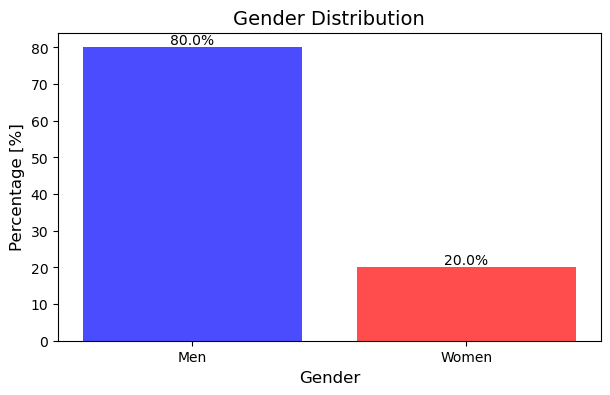

In [45]:
# Group the features DataFrame by gender for train data
features_by_gender = features_train_df.groupby('Gender')

# Define gender labels and colors for the plot
gender_labels = ['Men', 'Women']
colors = ['blue', 'red']

# Calculate the percentage of each gender in train data
gender_percentages = features_by_gender['Gender'].count() / features_by_gender['Gender'].count().sum() * 100

# Plot the gender distribution using a bar plot
plt.figure(figsize=(7, 4))

# Plot train data only
plt.bar(gender_labels, gender_percentages, color=colors, alpha=0.7)

# Set the labels for x-axis and y-axis, and the plot title
plt.xlabel("Gender", size=12)
plt.ylabel("Percentage [%]", size=12)
plt.title('Gender Distribution', size=14)

# Add text labels for percentage above the bars
for i in range(len(gender_labels)):
    plt.text(i, gender_percentages[i], f'{gender_percentages[i]:.1f}%', ha='center', va='bottom')

# Display the plot
plt.show()

#### Visualization the distribution of the age feature 

[22.0, 31.0, 33.0, 40.0, 42.0, 44.0, 46.0, 48.0, 49.0, 51.0, 52.0, 53.0, 54.0, 56.0, 59.0, 61.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 72.0, 73.0, 74.0, 78.0, 80.0, 85.0, 87.0]


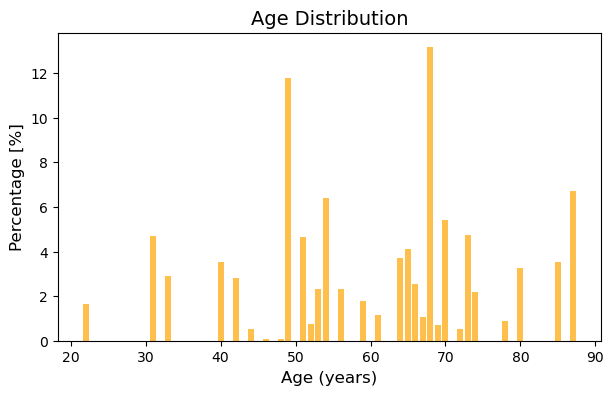

In [66]:
# Group the features DataFrame by age for train data
features_by_age = features_train_df.groupby('Age')

# Calculate the percentage of each age in train data
age_percentages = features_by_age['Age'].count() / features_by_age['Age'].count().sum() * 100
age_series = features_by_age['Age'].unique().tolist()
age_labels = [age[0] for age in age_series]

# Plot the age distribution using a bar plot
plt.figure(figsize=(7, 4))
plt.bar(age_labels, age_percentages, color='orange', alpha=0.7)

# Adding labels and title to the plot
plt.xlabel("Age (years)", size=12)
plt.ylabel("Percentage [%]", size=12)
plt.title('Age Distribution', size=14)

# Displaying the plot
plt.show()

#### Visualization the distribution of the weight feature 

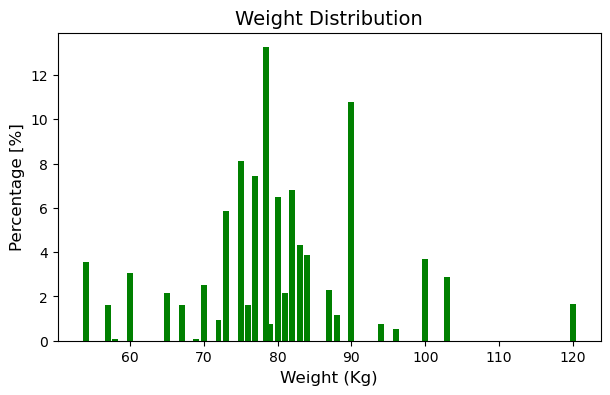

In [70]:
# Grouping the data by weight and creating separate dataframes for train datasets
features_by_weight = features_train_df.groupby('Weight')

# Plotting the train data below the x-axis
weight_percentages = features_by_weight['Weight'].count() / features_by_weight['Weight'].count().sum() * 100
weight_series = features_by_weight['Weight'].unique().tolist()
weight_labels = [age[0] for age in weight_series]

# Plot the weight distribution using a bar plot
plt.figure(figsize=(7, 4))
plt.bar(weight_labels, weight_percentages, label='Train', color='green')

# Adding labels and title to the plot
plt.xlabel("Weight (Kg)", size=12)
plt.ylabel("Percentage [%]", size=12)
plt.title('Weight Distribution', size=14)

# Displaying the plot
plt.show()

####  Number of cycles in each part

In [79]:
def Cycles_Bar_Plot(df):
    """
    Plot a bar chart of the number of cycles in the dataset.

    Args:
        df (pandas.DataFrame): Input DataFrame containing the data.
    """
    features_by_cycle = df.groupby('Cycles')
    cycle_series = features_by_cycle['Cycles'].unique().tolist()
    cycle_labels = [age[0] for age in cycle_series]

    plt.figure(figsize=(7, 4))
    plt.bar(cycle_labels, features_by_cycle['Cycles'].count(), color='maroon')
    plt.xlabel("Cycles")
    plt.ylabel("Count segments")
    plt.title('Number of Cycles')
    plt.show()

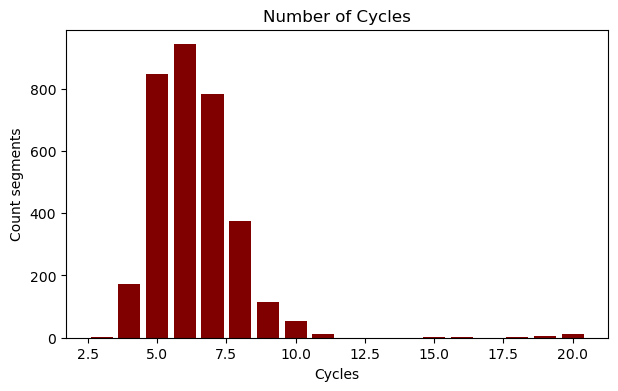

In [80]:
# Plot the cycles bar plot with the train & test data
Cycles_Bar_Plot(features_train_df)

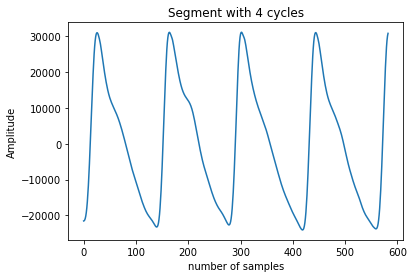

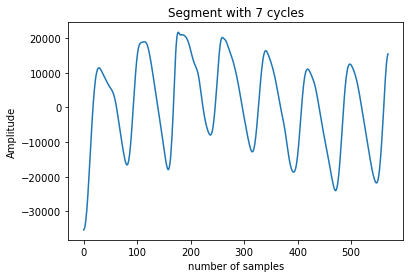

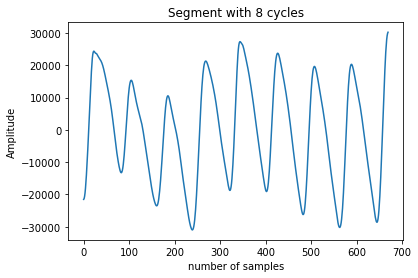

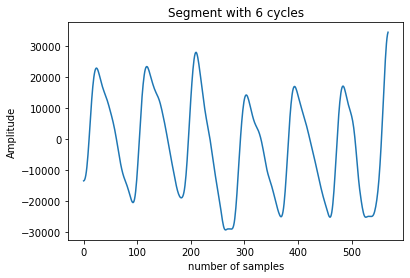

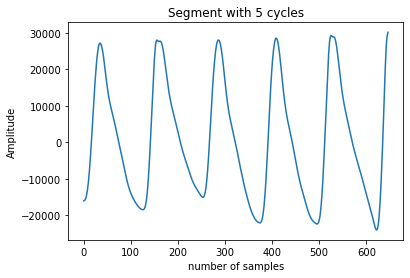

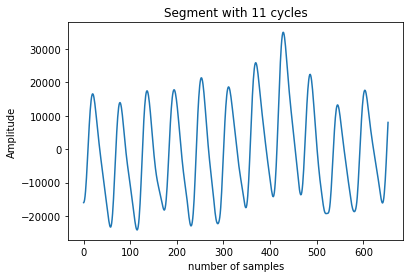

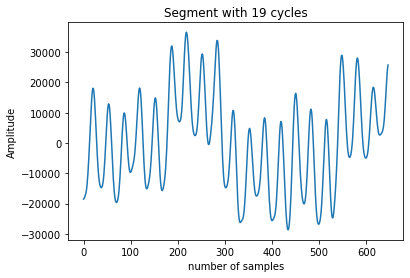

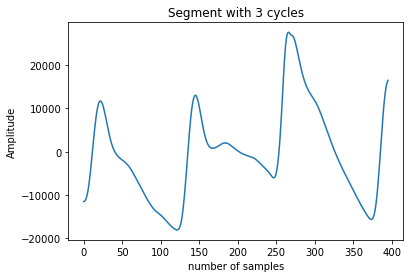

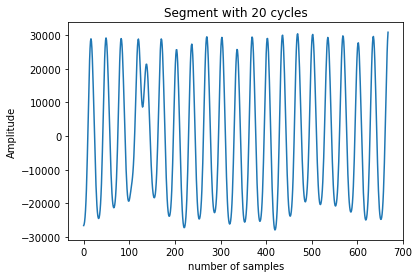

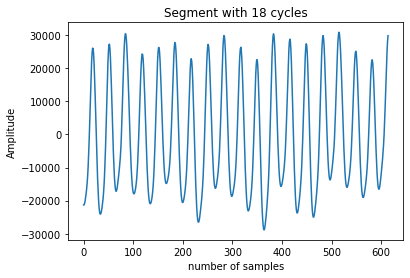

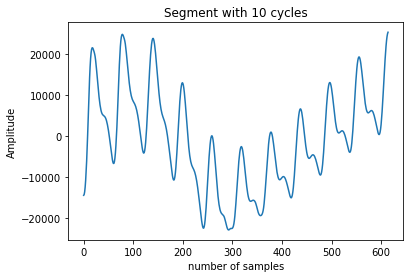

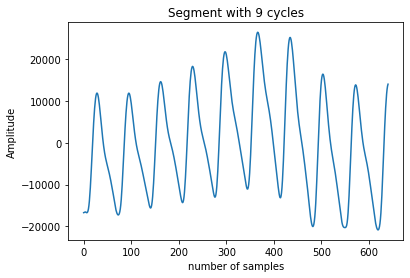

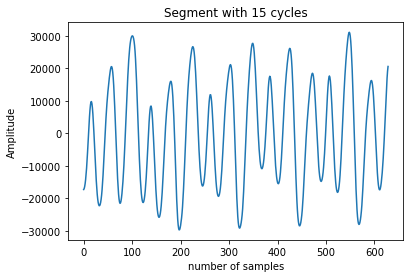

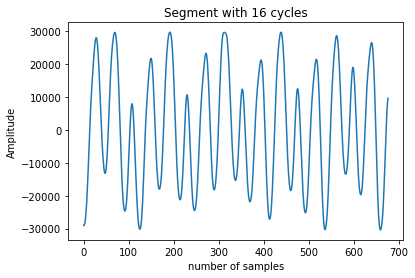

In [72]:
# Get unique cycles numbers in the training dataset
unique_cycles = features_train_df['Cycles'].unique()
unique_parts_df = pd.DataFrame([])

# Select one example for each unique cycles number
for unique in unique_cycles:
    unique_cycle = features_train_df[features_train_df['Cycles'] == unique]
    unique_part = unique_cycle.groupby(unique_cycle['Part'])
    for part in unique_part:
        part_df = part[1]
        unique_parts_df = pd.concat([unique_parts_df, part_df])
        break

# Plot and display the waveform data for each example
for ind in unique_parts_df.index:
    unique_parts_num = unique_parts_df['Part'][ind]
    unique_part = train_df[train_df['Part_Number'] == unique_parts_num]
    unique_wave = unique_part['PLETH_trend_removel']
    cycles_part = unique_part['Num_of_Cycles_in_part'].unique()[0]

    plt.title(f'Segment with {cycles_part} cycles')
    plt.xlabel('number of samples')
    plt.ylabel('Amplitude')
    plt.plot(unique_wave.values)
    plt.show()

#### Number of segments to every patient

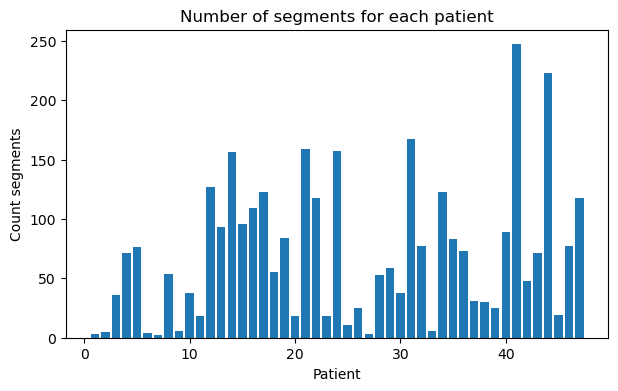

In [82]:
features_by_ID = features_train_df.groupby('ID')
id_series = features_by_ID['ID'].unique().tolist()
id_unique = [age[0] for age in id_series]
id_labels = range(1,len(id_unique)+1)

plt.figure(figsize=(7, 4))
plt.bar(id_labels, features_by_ID['ID'].count())
plt.xlabel("Patient")
plt.ylabel("Count segments")
plt.title('Number of segments for each patient')
plt.show()

#### Statistics on all the features

In [238]:
# Initialize empty arrays to store the statistical measures for each column
count_feature = mean_feature = std_feature = min_feature = val_25_prec_feature = val_50_prec_feature = val_75_prec_feature = max_feature = feature_name = np.array([])

# Iterate over each column in the features_train_df data frame
for column in features_train_df.columns:
    # Store the column name in the feature_name array
    feature_name = np.append(feature_name, column)
    
    # Calculate and store the statistical measures for the current column using the describe() function
    describe_col = features_train_df[column].describe()
    count_feature = np.append(count_feature, describe_col[0])
    mean_feature = np.append(mean_feature, describe_col[1])
    std_feature = np.append(std_feature, describe_col[2])
    min_feature = np.append(min_feature, describe_col[3])
    val_25_prec_feature = np.append(val_25_prec_feature, describe_col[4])
    val_50_prec_feature = np.append(val_50_prec_feature, describe_col[5])
    val_75_prec_feature = np.append(val_75_prec_feature, describe_col[6])
    max_feature = np.append(max_feature, describe_col[7])

# Create the features_statistic data frame and populate it with the collected statistical measures
features_statistic = pd.DataFrame()
features_statistic['feature_name'] = feature_name
features_statistic['count'] = count_feature
features_statistic['mean'] = mean_feature
features_statistic['std'] = std_feature
features_statistic['min'] = min_feature
features_statistic['25%'] = val_25_prec_feature
features_statistic['50%'] = val_50_prec_feature
features_statistic['75%'] = val_75_prec_feature
features_statistic['max'] = max_feature

# Return the features_statistic data frame
features_statistic

,feature_name,count,mean,std,min,25%,50%,75%,max
0,Part,3659.0,1830,1056.41,1,915.5,1830,2744.5,3659
1,Cycles,3659.0,6.44179,1.90988,3,5,6,7,20
2,ID,3659.0,4.01128e+07,8.74888e+06,2.20431e+07,3.23854e+07,3.84334e+07,4.89953e+07,5.34037e+07
3,Time_Delta_BP,3659.0,0 days 01:52:17.217819,0 days 01:09:26.772101,0 days 00:01:00,0 days 00:57:00,0 days 01:43:00,0 days 02:35:00,0 days 05:17:00
4,BaseLine_MAP,3659.0,89.9244,36.8161,38.3333,63,81,109.333,195.667
...,...,...,...,...,...,...,...,...,...
131,F6_STT_(-5),3455.0,0.000539015,0.000247373,0.000289494,0.000421927,0.000480298,0.000574981,0.00714012
132,F6_Avg_STT_Last_5_Norm,3659.0,0.483569,0.0168366,-0.510335,0.48142,0.483361,0.485641,0.504481
133,F6_Avg_STT_Last_5,3659.0,0.000541151,0.000242028,-0.008268,0.00044,0.000497,0.000578,0.005414
134,F6_Std_STT_Last_5_Norm,3659.0,0.00390002,0.00191525,0.00042,0.002818,0.003443,0.0043485,0.021536


#### Number of Nan values in every feature

In [83]:
# Count the number of NaN values in each column in the train data sets
nan_counts = features_train_df.isnull().sum()
print(f'The number of NaN values in each column is:\n{nan_counts[nan_counts > 0]}')

The number of NaN values in each column is:
Part                              1
F1_Area_cycle_Norm_(-4)           1
F1_Area_cycle_(-4)                1
F1_Area_cycle_Norm_(-5)         172
F1_Area_cycle_(-5)              172
F2_Width_25_cycle_Norm_(-4)       1
F2_Width_50_cycle_Norm_(-4)       1
F2_Width_75_cycle_Norm_(-4)       1
F2_Width_25_cycle_Norm_(-5)     172
F2_Width_50_cycle_Norm_(-5)     172
F2_Width_75_cycle_Norm_(-5)     172
F3_ROR_cycle_Norm_(-4)            1
F3_ROR_cycle_(-4)                 1
F3_ROF_cycle_Norm_(-4)            1
F3_ROF_cycle_(-4)                 1
F3_ROR_cycle_Norm_(-5)          172
F3_ROR_cycle_(-5)               172
F3_ROF_cycle_Norm_(-5)          172
F3_ROF_cycle_(-5)               172
F4_Time_cycle_Norm(sec)_(-4)      1
F4_Time_cycle(sec)_(-4)           1
F4_Time_cycle_Norm(sec)_(-5)    172
F4_Time_cycle(sec)_(-5)         172
F5_Y_high_max_(-4)                1
F5_Y_high_max_(-5)              172
F6_STT_(-4)                       1
F6_STT_(-5)         

#### Correlation Matrix

In [83]:
def Corr_Matrix(X):
    """
    Create a correlation matrix for the given DataFrame.

    Args:
        X (pandas.DataFrame): Input DataFrame.
    """
    # Normalize the features in the DataFrame
    X0 = ((X - X.mean(axis=0)) / np.linalg.norm(X - X.mean(axis=0), axis=0)).values
    norm_features_df = pd.DataFrame(X0, columns=X.columns)

    # Create the correlation matrix
    C = X0.T @ X0

    # Plot the correlation matrix
    plt.figure(figsize=(10, 10))
    plt.title('Correlation Matrix')
    plt.imshow(C, cmap='bwr')
    plt.colorbar()

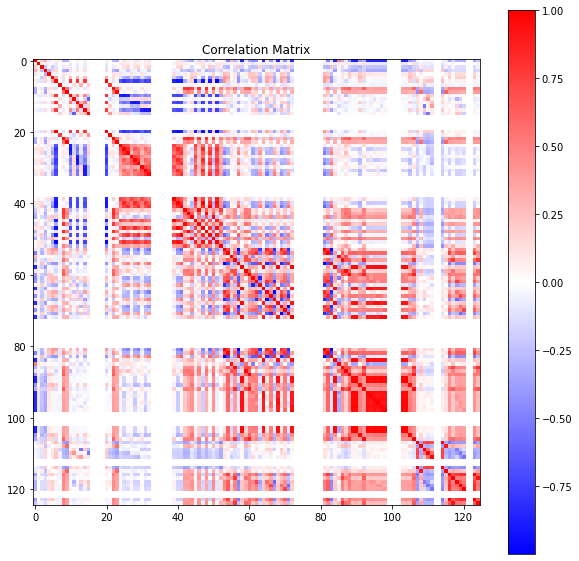

In [84]:
# Create a correlation matrix of only the features in the features_train_df
X = features_train_df.drop(['Part', 'ID', 'MAP', 'L2_Change_MAP', 'L3_Ratio_MAP', 'L4_SBP', 'L5_DBP', 'Time_Delta_BP'], axis=1)
Corr_Matrix(X)

#### Boxplot to the distribution of each feature

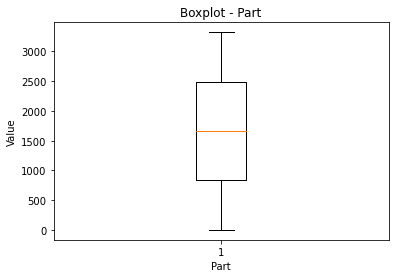

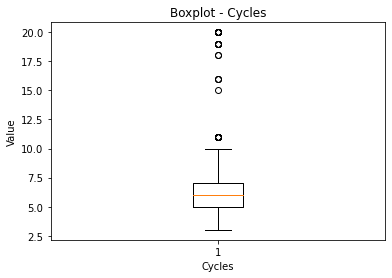

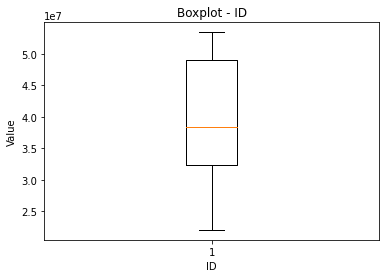

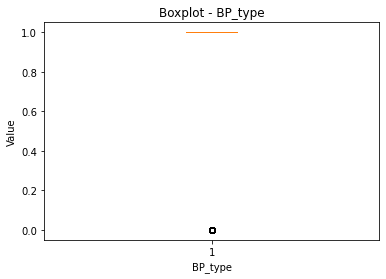

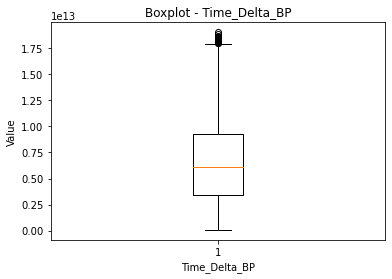

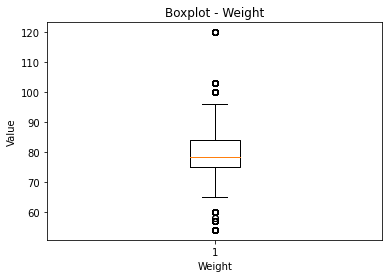

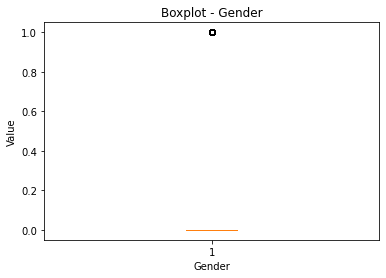

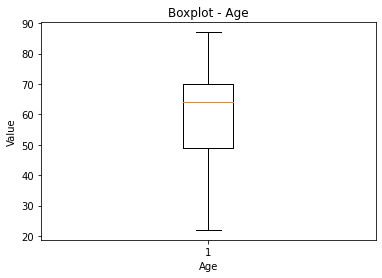

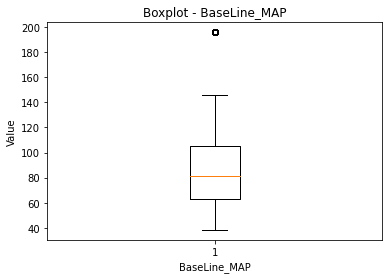

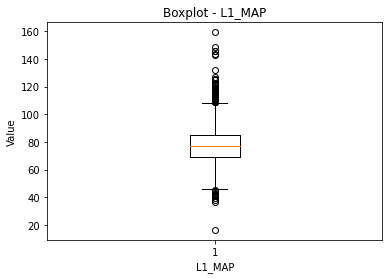

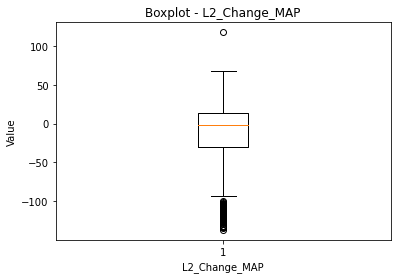

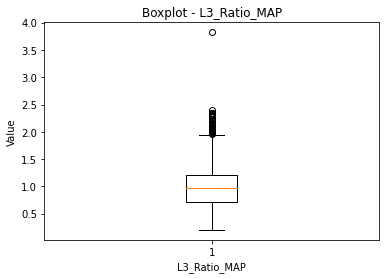

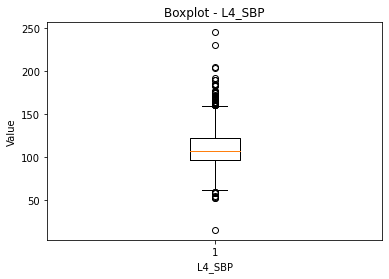

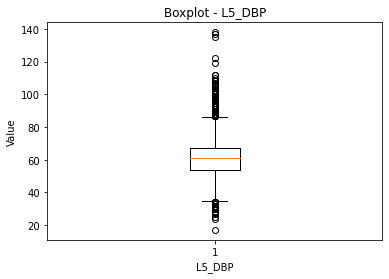

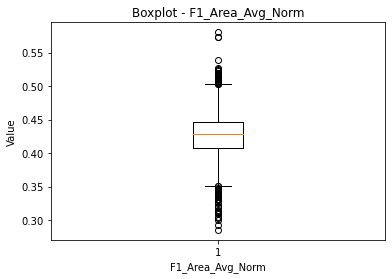

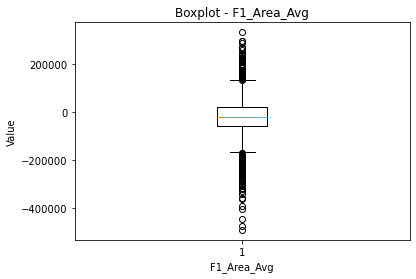

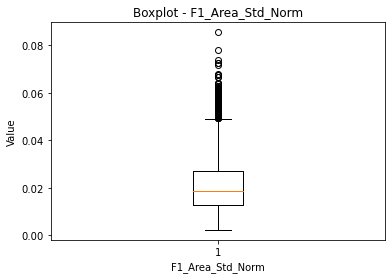

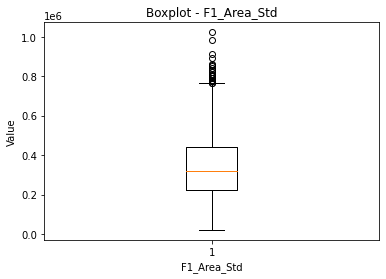

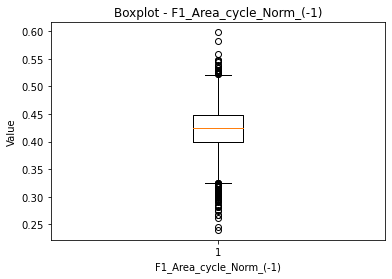

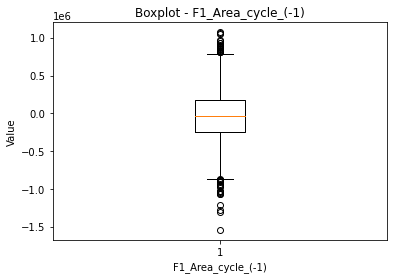

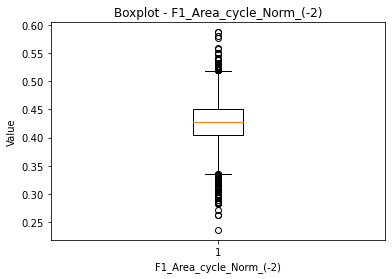

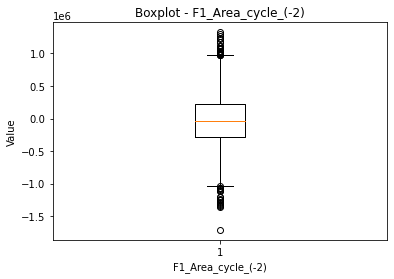

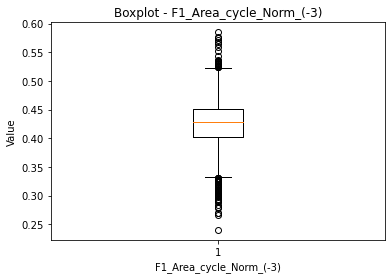

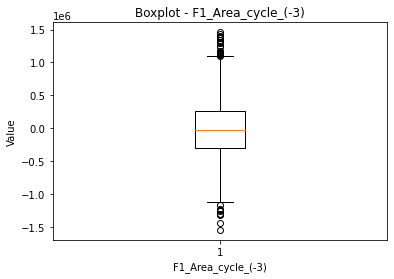

C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


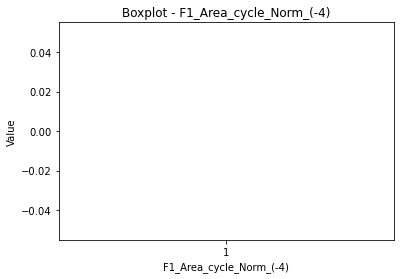

C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


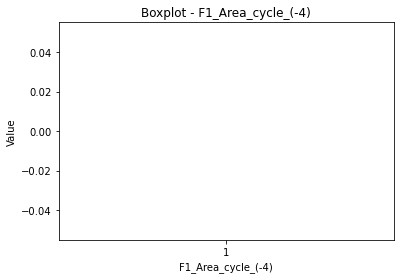

C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


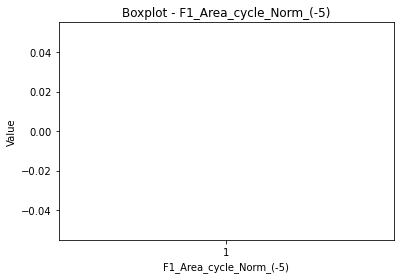

C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


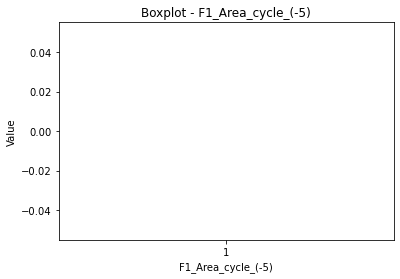

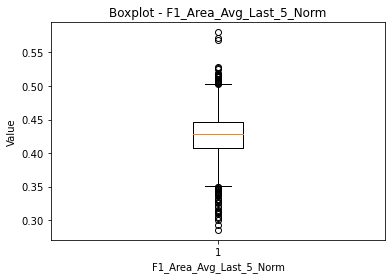

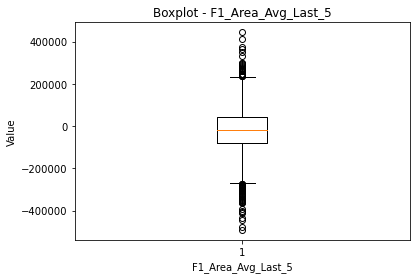

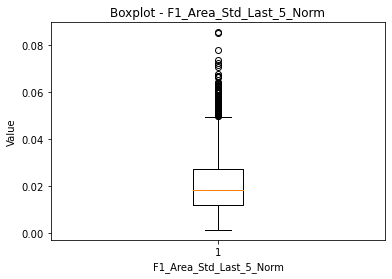

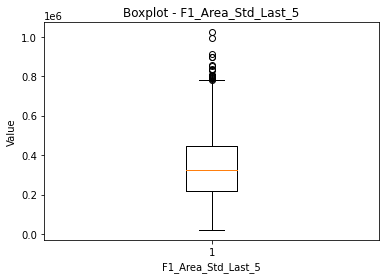

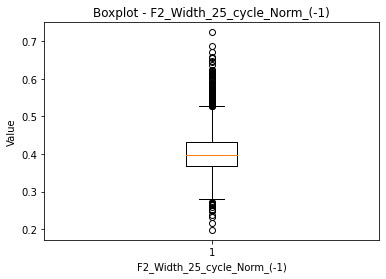

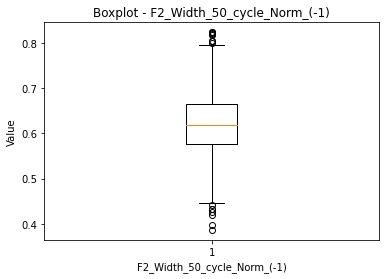

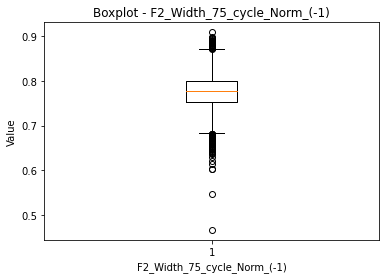

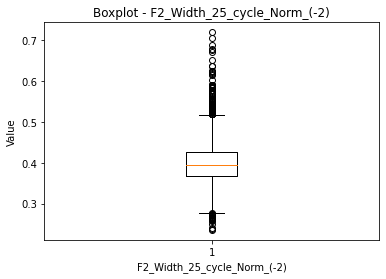

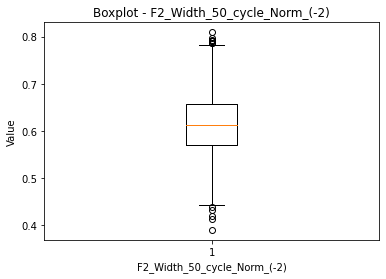

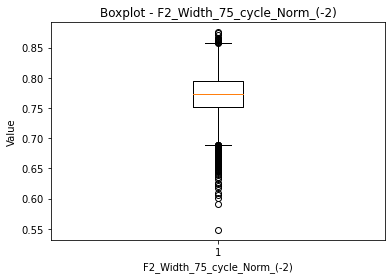

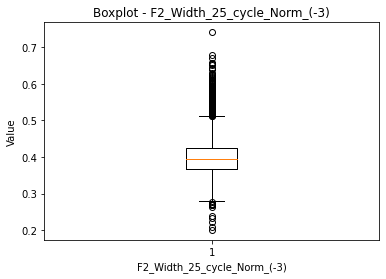

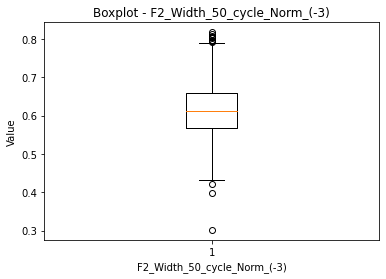

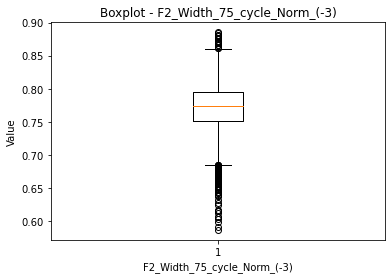

C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


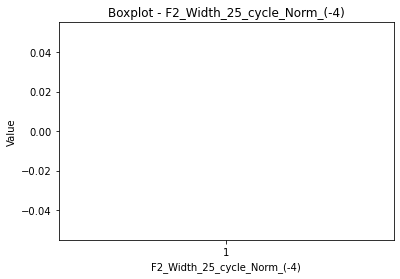

C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


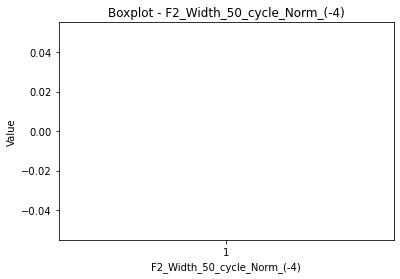

C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


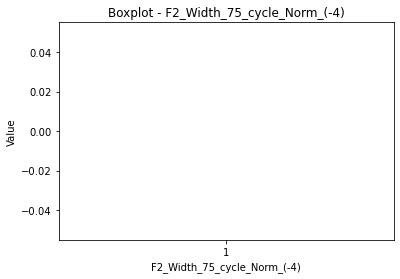

C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


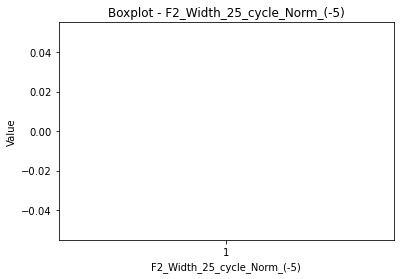

C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


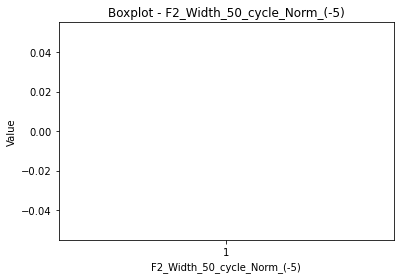

C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


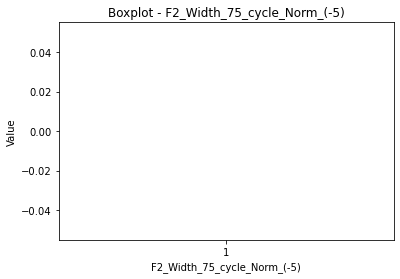

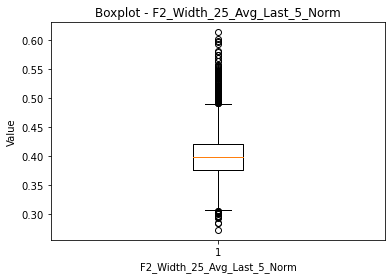

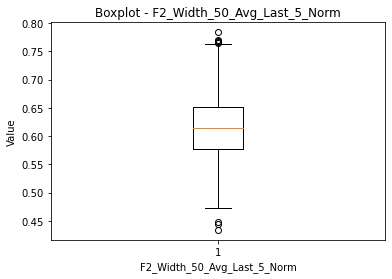

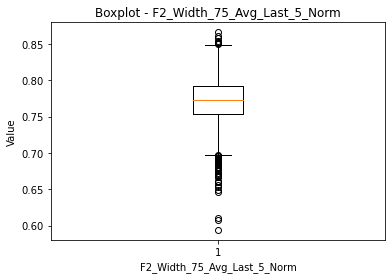

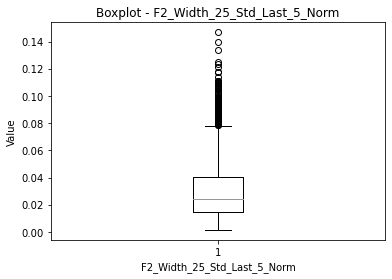

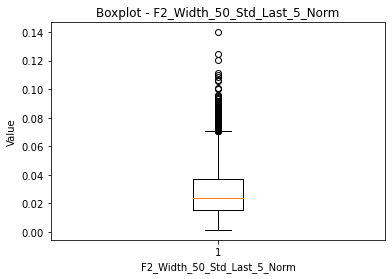

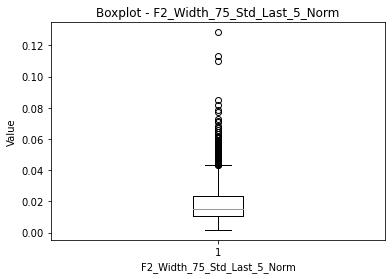

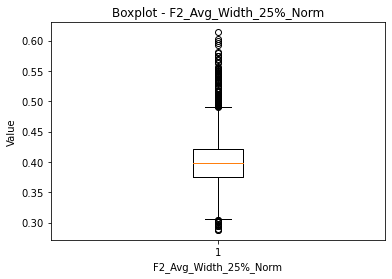

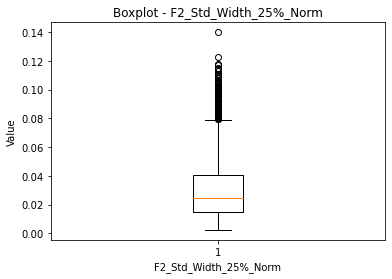

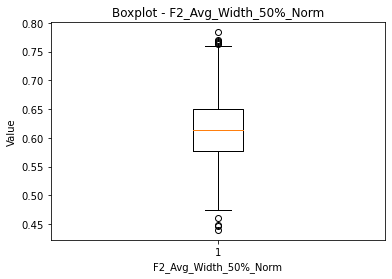

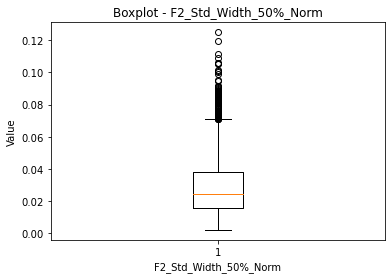

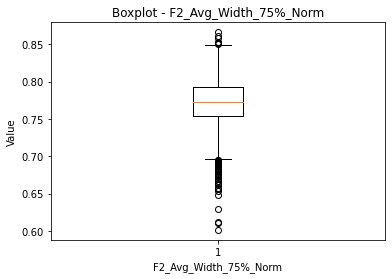

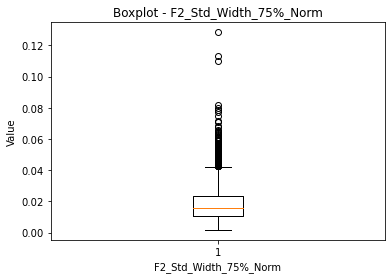

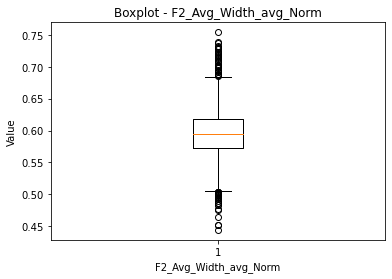

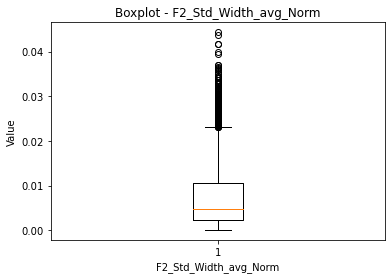

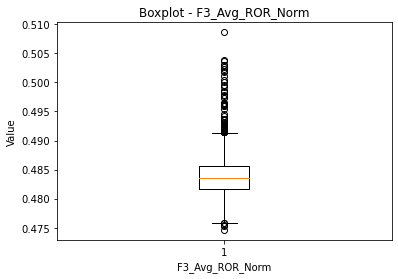

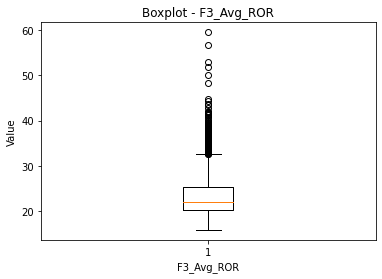

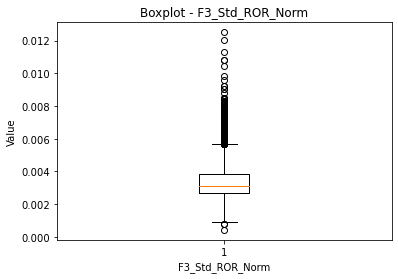

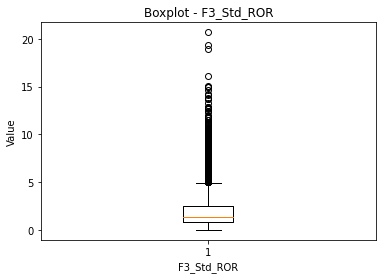

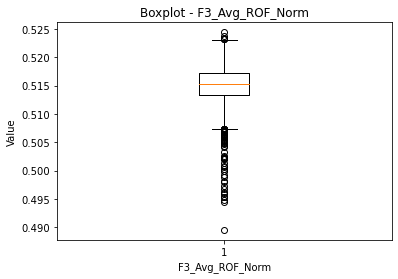

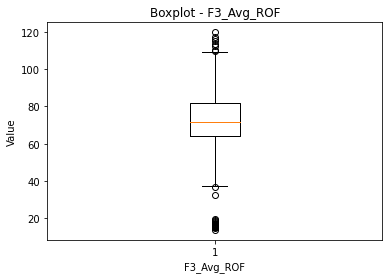

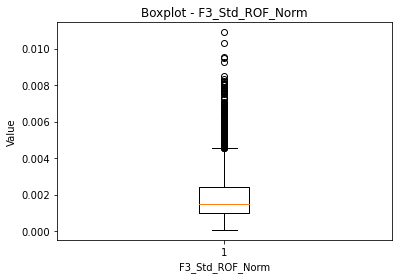

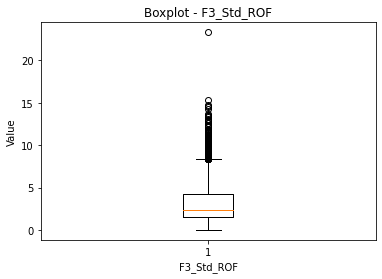

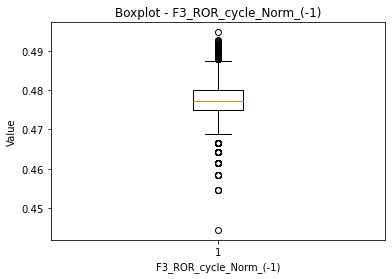

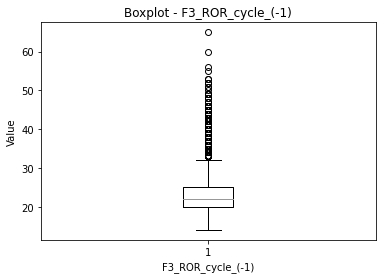

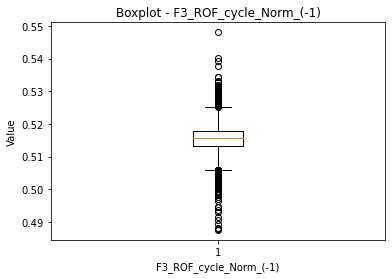

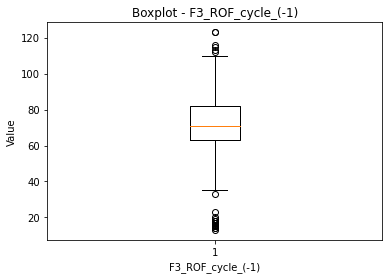

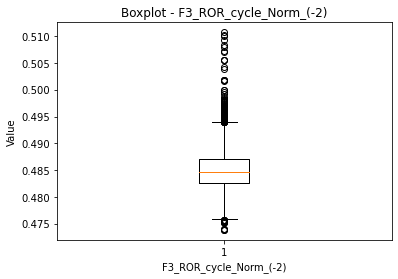

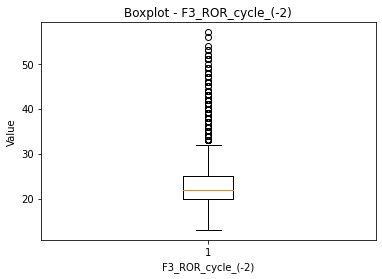

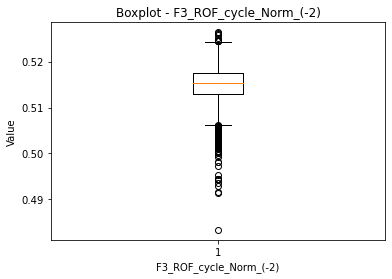

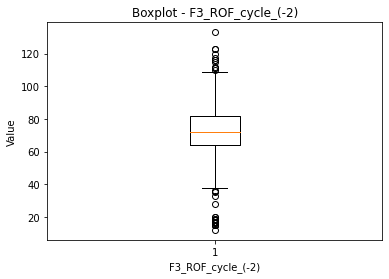

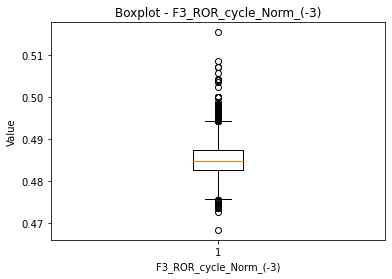

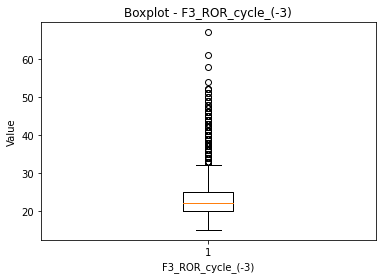

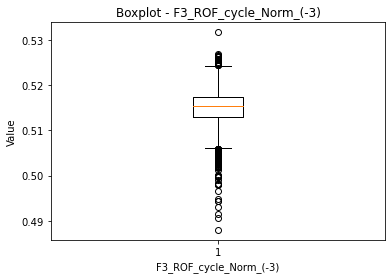

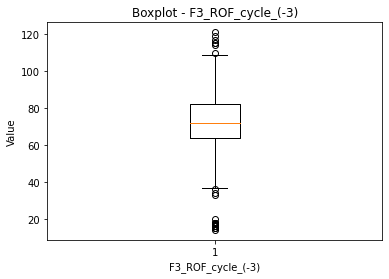

C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


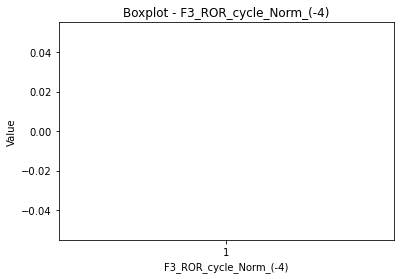

C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


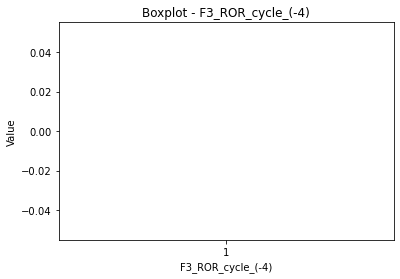

C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


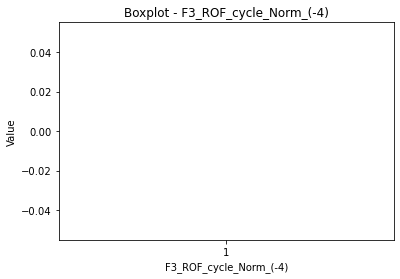

C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


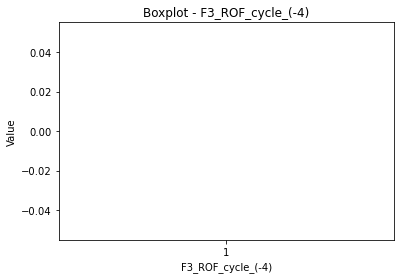

C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


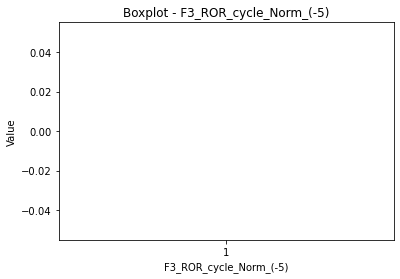

C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


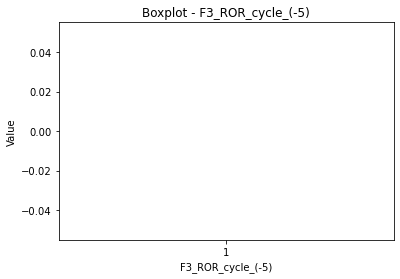

C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


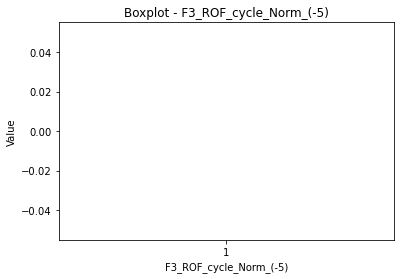

C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


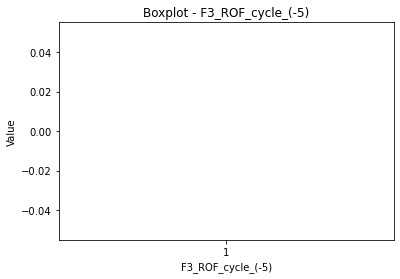

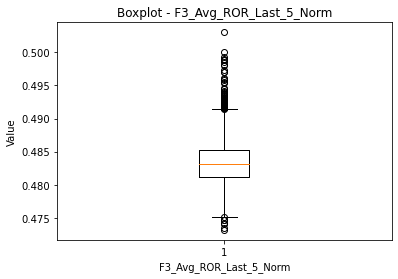

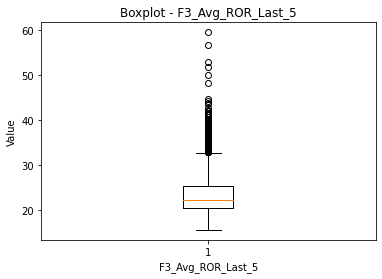

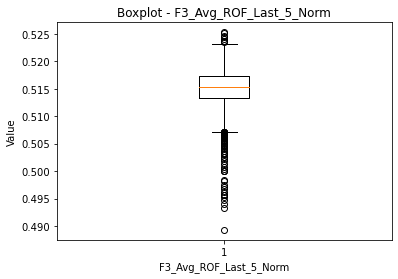

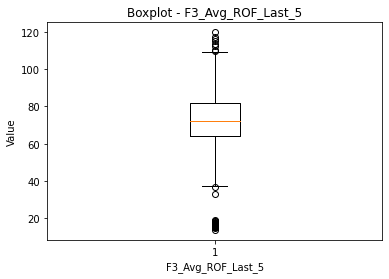

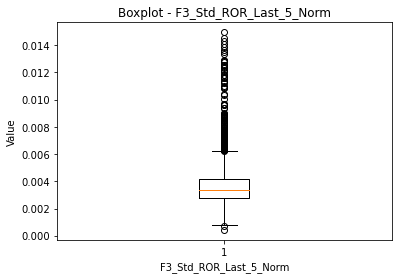

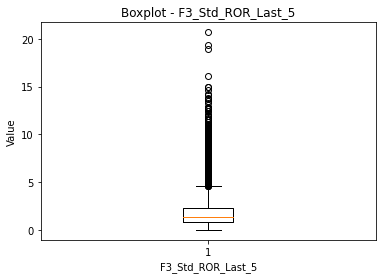

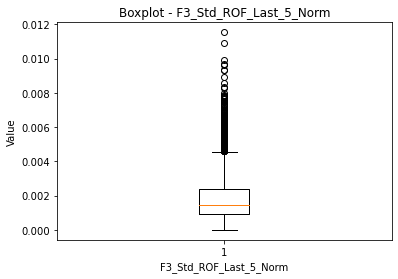

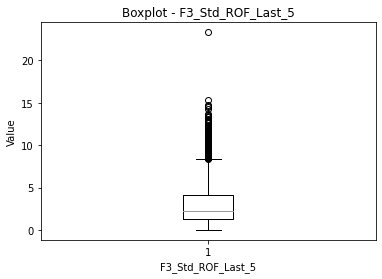

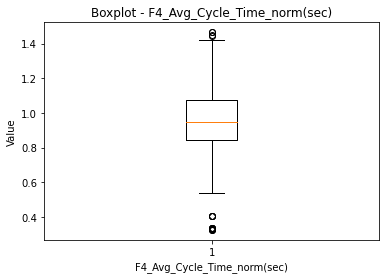

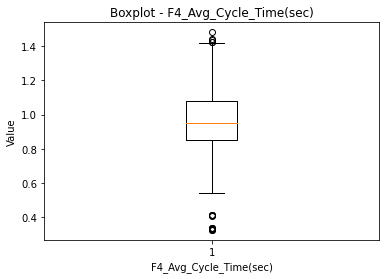

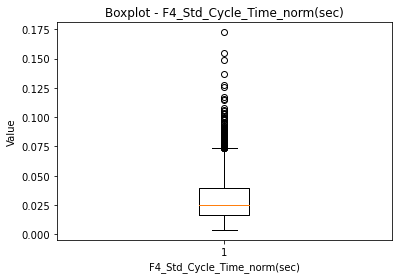

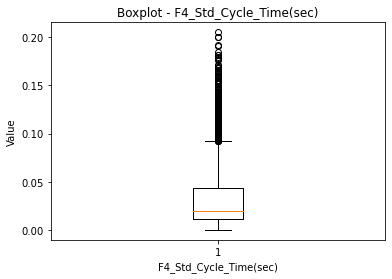

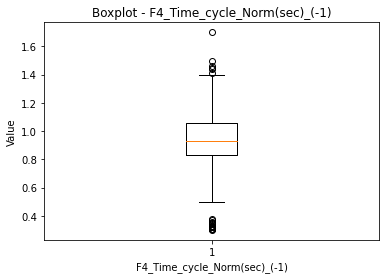

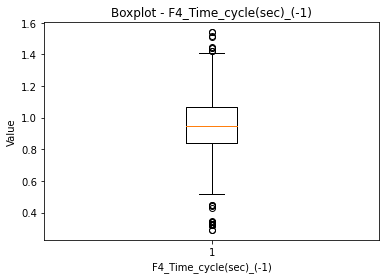

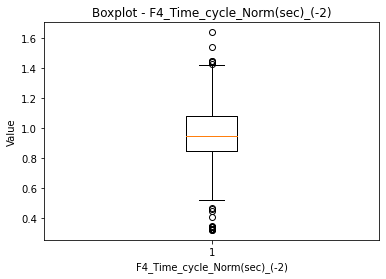

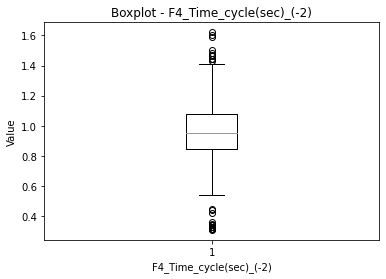

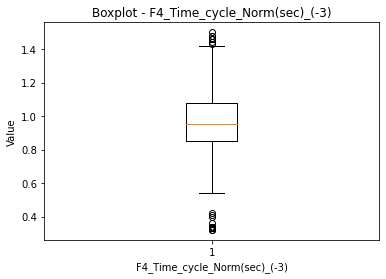

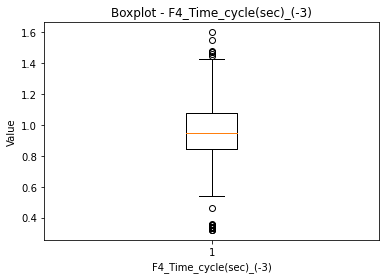

C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


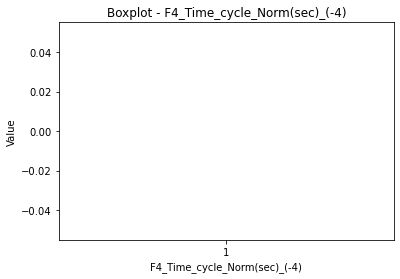

C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


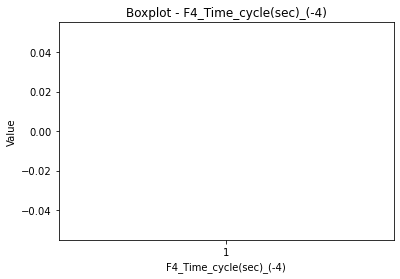

C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


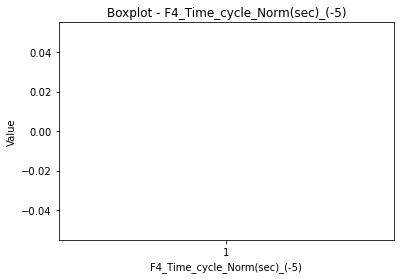

C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


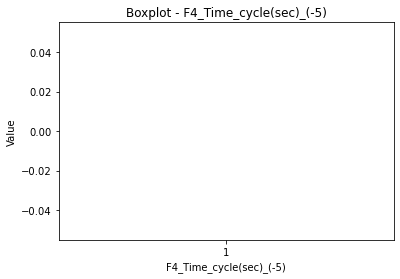

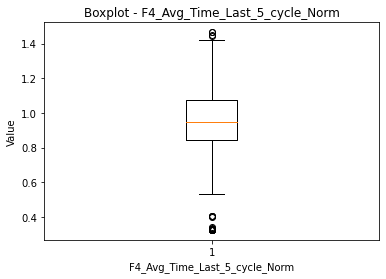

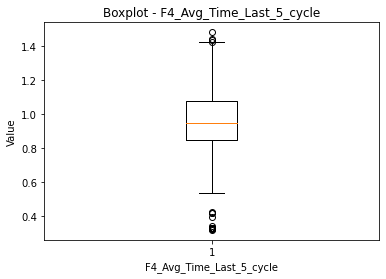

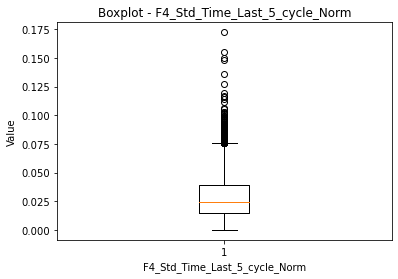

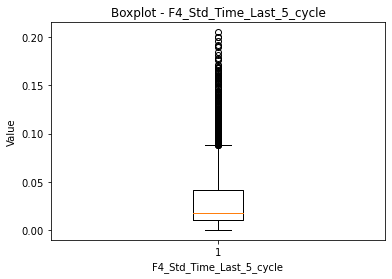

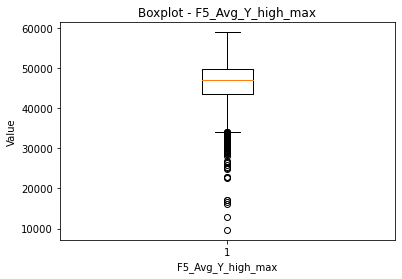

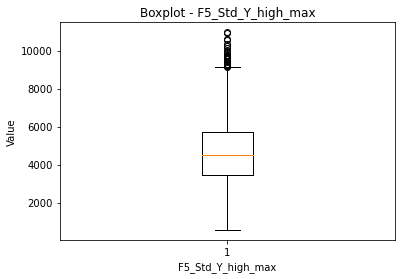

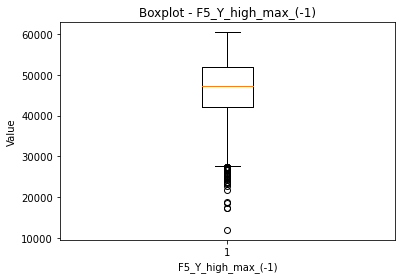

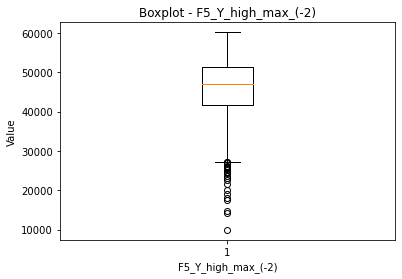

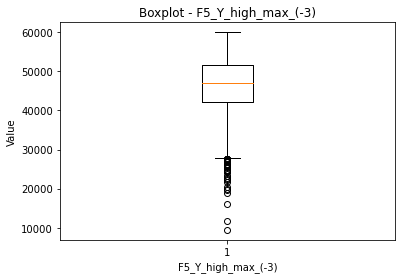

C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


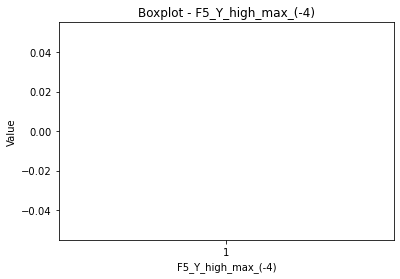

C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


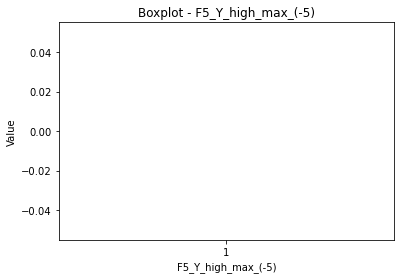

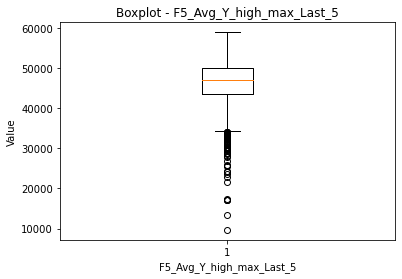

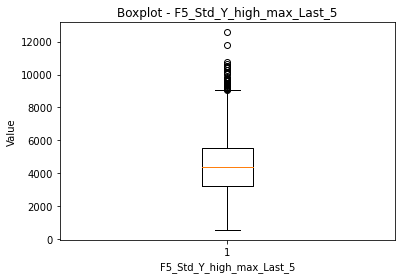

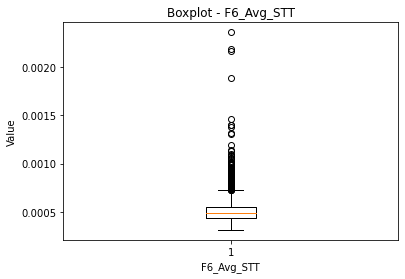

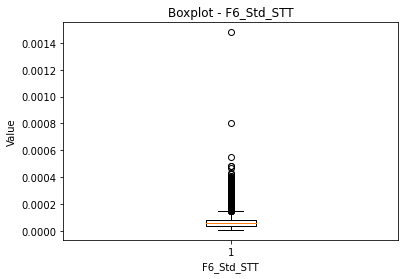

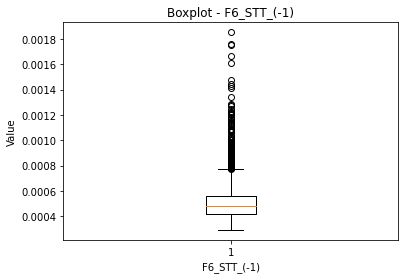

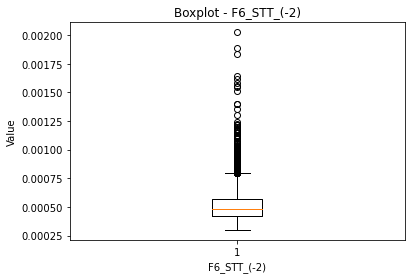

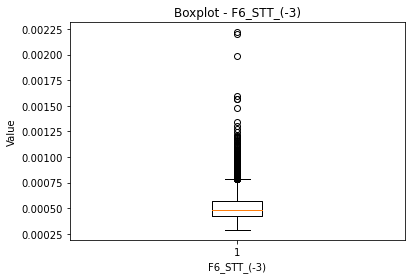

C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


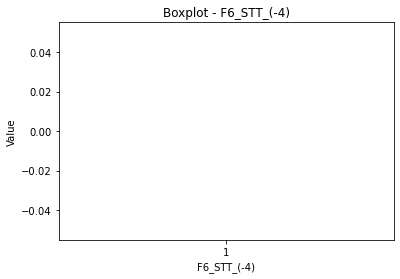

C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
C:\Users\shaha\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


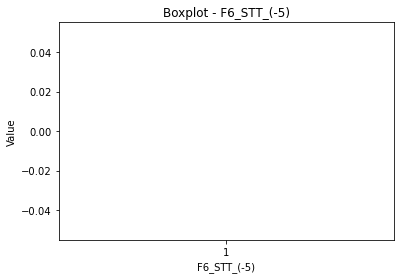

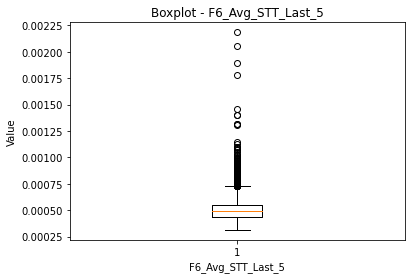

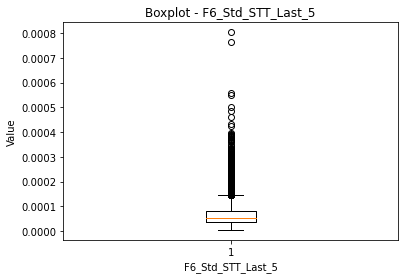

In [88]:
# Plot boxplots for each feature
for column in features_train_df.columns:
    plt.boxplot(features_train_df[column])
    plt.xlabel(column)
    plt.ylabel('Value')
    plt.title(f'Boxplot - {column}')
    plt.show()

#### Number of outliers by extreme value analysis

In [93]:
# Find outliers by extreme value analysis
def extreme_values_analysis(df):
    numeric_columns = df.select_dtypes(include=np.number)
    threshold = 3
    extreme_values_count = ((numeric_columns-numeric_columns.mean())/numeric_columns.std() > threshold).sum()
    print(f'Outliers by extreme values count per column:\n{extreme_values_count}')

In [94]:
extreme_values_analysis(features_train_df)

Train: Outliers by extreme values count per column:
Part                  0
Cycles               25
ID                    0
BP_type               0
Time_Delta_BP         0
                     ..
F6_STT_(-3)          53
F6_STT_(-4)          60
F6_STT_(-5)          56
F6_Avg_STT_Last_5    43
F6_Std_STT_Last_5    77
Length: 133, dtype: int64
Test: Outliers by extreme values count per column:
Part                  0
Cycles               11
ID                    0
BP_type               0
Time_Delta_BP         0
                     ..
F6_STT_(-3)          23
F6_STT_(-4)          17
F6_STT_(-5)          13
F6_Avg_STT_Last_5    11
F6_Std_STT_Last_5    23
Length: 133, dtype: int64


# Corrections that arose from the EDA 

#### Drop the segments with less then 12 cycles
The amount of cycles that make up each segment was investigated and it was found that there are segments with an unreasonable amount of cycles that create a poor quality PPG signal. It was defined that a segment with more than 12 cycles is an abnormal signal and therefore it was removed from the data set.

In [86]:
def drop_parts_with_less_than_12_cycles(df, kind):
    """
    Drops all the segments from the DataFrame that have more than 12 cycles.

    Parameters:
        df (DataFrame): The input DataFrame containing the segments and cycles information.
        kind (str): The variable specifying the data type or kind of the DataFrame.

    Returns:
        DataFrame: The modified DataFrame after dropping the segments.
    """
    parts_before = df['Part'].values[-1]

    # Filter out the segments with more than 12 cycles.
    df = df[df['Cycles'] < 12]

    # Reset the index and update the segment numbers.
    df.reset_index(drop=True, inplace=True)
    df['Part'] = df.index + 1
    
    # Print the number of segments that drop in this process.
    parts_less_then_12_cycles = df['Part'].values[-1]
    print(f'{kind} segments with less then 12 cycles: {parts_less_then_12_cycles}, which are: {np.round((parts_less_then_12_cycles/parts_before)*100,2)}%')
    
    return df, parts_before

In [87]:
# Apply the drop_parts_with_less_then_12_parts function on the train & test datasets. 
features_train_df, parts_before_train = drop_parts_with_less_than_12_cycles(features_train_df, 'Train')
features_test_df, parts_before_test = drop_parts_with_less_than_12_cycles(features_test_df, 'Test')

Train segments with less then 12 cycles: 879, which are: 100.0%
Test segments with less then 12 cycles: 879, which are: nan%


C:\Users\shaha\AppData\Local\Temp\ipykernel_26548\3426030110.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Part'] = df.index + 1


# Save the features data

In [135]:
# Save the new train features df after drop the parts that has over 12 cycles
file_path_train = f'data/train_features_df_run{run}.xlsx'
features_train_df.to_excel(file_path_train, index=False)

# Save the test features df
file_path_test = f'data/test_features_df_run{run}.xlsx'
features_test_df.to_excel(file_path_test, index=False)